# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

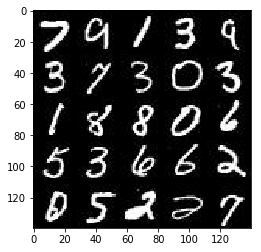

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

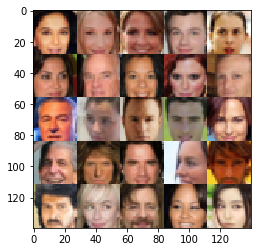

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    
    real_input=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    z=tf.placeholder(tf.float32,(None,z_dim),name='z')
    l_r=tf.placeholder(tf.float32,None,name='learning_rate')
    return real_input, z, l_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [110]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator',reuse=reuse):
       
        #1st Convolution 14x14x64
        x1=tf.layers.conv2d(images,64,4,strides=2,padding='same')
        x1=tf.maximum(x1*alpha,x1)
        
        #2nd Convolution 7x7x128
        
        x2=tf.layers.conv2d(x1,128,4,strides=2,padding='same')
        x2=tf.layers.batch_normalization(x2,training=True)
        x2=tf.maximum(x2*alpha,x2)
        
        #3rd Convolution 4x4x256
        
        x3=tf.layers.conv2d(x2,256,4,strides=2,padding='same')
        x3=tf.layers.batch_normalization(x3,training=True)
        x3=tf.maximum(x3*alpha,x3)

        #Fully connected layer
        flatten=tf.contrib.layers.flatten(x3)
        logits=tf.contrib.layers.fully_connected(flatten,1,activation_fn=None)
        output=tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [111]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator',reuse=not is_train):
        
        #Reshape vector -> 7x7x512
        x0 = tf.layers.dense(z, 7*7*512)
        x0=tf.reshape(x0,[-1,7,7,512])
        x0=tf.layers.batch_normalization(x0,training=is_train)
        x0=tf.maximum(x0*alpha,x0)
        
        #1st T-Convolution -> 14x14x256
        x1=tf.layers.conv2d_transpose(x0,256,5,strides=2,padding='same')
        x1=tf.layers.batch_normalization(x1,training=is_train)
        x1=tf.maximum(x1*alpha,x1)
        
        #2nd T-Convolution -> 12x12x256
        #x2=tf.layers.conv2d_transpose(x1,256,4,strides=2,padding='same')
        #x2=tf.layers.batch_normalization(x2,training=is_train)
        #x2=tf.maximum(x2*alpha,x2)
        
        #3rd T-Convolution -> 24x24x128
        #x3=tf.layers.conv2d_transpose(x2,128,4,strides=2,padding='same')
        #x3=tf.layers.batch_normalization(x3,training=is_train)
        #x3=tf.maximum(x3*alpha,x3)
        
        #Output layer
        out=tf.layers.conv2d_transpose(x1,out_channel_dim,5,strides=2,padding='same')
        out=tf.tanh(out)
        
        
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [112]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    
    #Model Outputs
    d_output_real,d_logits_real=discriminator(input_real, reuse=False)
    g_output=generator(input_z, out_channel_dim, is_train=True)
    d_output_fake,d_logits_fake=discriminator(g_output, reuse=True)
    
    #Losses
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_real),logits=d_logits_real))
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_logits_fake),logits=d_logits_fake))
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_logits_fake),logits=d_logits_fake))
    d_loss=d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [113]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    #get weights and biases to optimize
    
    t_vars=tf.trainable_variables()
    d_vars=[variable for variable in t_vars if variable.name.startswith('discriminator')]
    g_vars=[variable for variable in t_vars if variable.name.startswith('generator')]
    
    #optimize
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt_d=tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
        d_opt=opt_d.minimize(d_loss,var_list=d_vars)
        opt_g=tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
        g_opt=opt_g.minimize(g_loss,var_list=g_vars)
    
    
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [114]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [115]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print(celeba_dataset.image_mode)

RGB


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [119]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")

    """
    # TODO: Build Model
    #Define output channels for images
    if data_image_mode =='RGB':
        output_channels=3
    else:
        output_channels=1
    #Build model  
    
    real_input, z, learn_rate=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss=model_loss(real_input, z, output_channels)
    d_opt, g_opt=model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch=1
            
            for batch_images in get_batches(batch_size):
                
                batch_images=batch_images*2
               
                # TODO: Train Model
                #Initialize z - input
                z_r=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                gen_loss,_=sess.run((g_loss,g_opt),feed_dict={real_input:batch_images,learn_rate:learning_rate,z:z_r})
                dis_loss,_=sess.run((d_loss,d_opt),feed_dict={real_input:batch_images,learn_rate:learning_rate,z:z_r})
                gen_loss,_=sess.run((g_loss,g_opt),feed_dict={real_input:batch_images,learn_rate:learning_rate,z:z_r})
                
                print("Epoch:{}...".format(epoch_i),"Batch: {}...".format(batch),"Discriminator Loss: {:.4f}...".format(dis_loss),"Generator Loss: {:.4f}".format(gen_loss))
                if batch%100==0:
                    show_generator_output(sess, 9, z, output_channels, data_image_mode)
                
                batch+=1
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:0... Batch: 1... Discriminator Loss: 6.4931... Generator Loss: 0.1426
Epoch:0... Batch: 2... Discriminator Loss: 4.7927... Generator Loss: 0.2979
Epoch:0... Batch: 3... Discriminator Loss: 4.5337... Generator Loss: 0.2721
Epoch:0... Batch: 4... Discriminator Loss: 4.0996... Generator Loss: 0.5216
Epoch:0... Batch: 5... Discriminator Loss: 4.0623... Generator Loss: 0.7949
Epoch:0... Batch: 6... Discriminator Loss: 3.2523... Generator Loss: 1.1265
Epoch:0... Batch: 7... Discriminator Loss: 3.2392... Generator Loss: 1.2448
Epoch:0... Batch: 8... Discriminator Loss: 3.2863... Generator Loss: 1.2274
Epoch:0... Batch: 9... Discriminator Loss: 2.5879... Generator Loss: 1.5356
Epoch:0... Batch: 10... Discriminator Loss: 2.2354... Generator Loss: 1.6827
Epoch:0... Batch: 11... Discriminator Loss: 2.7261... Generator Loss: 1.2631
Epoch:0... Batch: 12... Discriminator Loss: 2.8241... Generator Loss: 1.3939
Epoch:0... Batch: 13... Discriminator Loss: 2.9297... Generator Loss: 1.0554
Epoch:0.

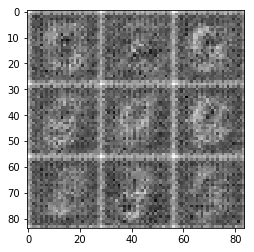

Epoch:0... Batch: 26... Discriminator Loss: 1.8269... Generator Loss: 0.9024
Epoch:0... Batch: 27... Discriminator Loss: 2.0360... Generator Loss: 0.7606
Epoch:0... Batch: 28... Discriminator Loss: 1.8194... Generator Loss: 1.0401
Epoch:0... Batch: 29... Discriminator Loss: 1.9991... Generator Loss: 0.7201
Epoch:0... Batch: 30... Discriminator Loss: 1.9456... Generator Loss: 0.8836
Epoch:0... Batch: 31... Discriminator Loss: 1.8304... Generator Loss: 0.8996
Epoch:0... Batch: 32... Discriminator Loss: 1.7494... Generator Loss: 0.6931
Epoch:0... Batch: 33... Discriminator Loss: 1.8114... Generator Loss: 0.8177
Epoch:0... Batch: 34... Discriminator Loss: 1.6966... Generator Loss: 0.9949
Epoch:0... Batch: 35... Discriminator Loss: 1.7334... Generator Loss: 0.7110
Epoch:0... Batch: 36... Discriminator Loss: 1.7279... Generator Loss: 0.7747
Epoch:0... Batch: 37... Discriminator Loss: 1.7119... Generator Loss: 0.8861
Epoch:0... Batch: 38... Discriminator Loss: 1.6884... Generator Loss: 0.7172

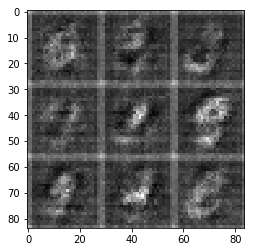

Epoch:0... Batch: 51... Discriminator Loss: 1.5794... Generator Loss: 0.5267
Epoch:0... Batch: 52... Discriminator Loss: 1.5415... Generator Loss: 1.1983
Epoch:0... Batch: 53... Discriminator Loss: 1.5996... Generator Loss: 0.5306
Epoch:0... Batch: 54... Discriminator Loss: 1.5913... Generator Loss: 1.1885
Epoch:0... Batch: 55... Discriminator Loss: 1.5797... Generator Loss: 0.5339
Epoch:0... Batch: 56... Discriminator Loss: 1.5632... Generator Loss: 1.0596
Epoch:0... Batch: 57... Discriminator Loss: 1.4924... Generator Loss: 0.6589
Epoch:0... Batch: 58... Discriminator Loss: 1.4399... Generator Loss: 0.8372
Epoch:0... Batch: 59... Discriminator Loss: 1.4759... Generator Loss: 1.0845
Epoch:0... Batch: 60... Discriminator Loss: 1.5503... Generator Loss: 0.4525
Epoch:0... Batch: 61... Discriminator Loss: 1.6398... Generator Loss: 1.2341
Epoch:0... Batch: 62... Discriminator Loss: 1.6878... Generator Loss: 0.4715
Epoch:0... Batch: 63... Discriminator Loss: 1.5239... Generator Loss: 1.1212

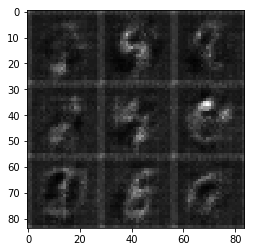

Epoch:0... Batch: 76... Discriminator Loss: 1.4146... Generator Loss: 1.3647
Epoch:0... Batch: 77... Discriminator Loss: 1.6030... Generator Loss: 0.4027
Epoch:0... Batch: 78... Discriminator Loss: 1.4202... Generator Loss: 1.3822
Epoch:0... Batch: 79... Discriminator Loss: 1.4912... Generator Loss: 0.5916
Epoch:0... Batch: 80... Discriminator Loss: 1.4534... Generator Loss: 0.9367
Epoch:0... Batch: 81... Discriminator Loss: 1.3959... Generator Loss: 0.8462
Epoch:0... Batch: 82... Discriminator Loss: 1.4746... Generator Loss: 0.7321
Epoch:0... Batch: 83... Discriminator Loss: 1.4649... Generator Loss: 0.8377
Epoch:0... Batch: 84... Discriminator Loss: 1.3937... Generator Loss: 0.6265
Epoch:0... Batch: 85... Discriminator Loss: 1.3356... Generator Loss: 1.3008
Epoch:0... Batch: 86... Discriminator Loss: 1.4099... Generator Loss: 0.5275
Epoch:0... Batch: 87... Discriminator Loss: 1.3987... Generator Loss: 1.0462
Epoch:0... Batch: 88... Discriminator Loss: 1.4433... Generator Loss: 0.7856

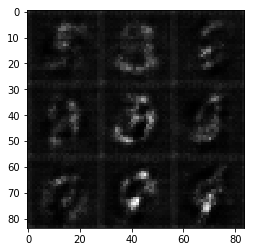

Epoch:0... Batch: 101... Discriminator Loss: 1.3087... Generator Loss: 1.0282
Epoch:0... Batch: 102... Discriminator Loss: 1.3174... Generator Loss: 0.7304
Epoch:0... Batch: 103... Discriminator Loss: 1.3371... Generator Loss: 1.0692
Epoch:0... Batch: 104... Discriminator Loss: 1.2984... Generator Loss: 0.7346
Epoch:0... Batch: 105... Discriminator Loss: 1.3344... Generator Loss: 0.7894
Epoch:0... Batch: 106... Discriminator Loss: 1.2890... Generator Loss: 1.0583
Epoch:0... Batch: 107... Discriminator Loss: 1.3564... Generator Loss: 0.5927
Epoch:0... Batch: 108... Discriminator Loss: 1.3080... Generator Loss: 1.1945
Epoch:0... Batch: 109... Discriminator Loss: 1.3607... Generator Loss: 0.5159
Epoch:0... Batch: 110... Discriminator Loss: 1.3271... Generator Loss: 1.4740
Epoch:0... Batch: 111... Discriminator Loss: 1.5192... Generator Loss: 0.3775
Epoch:0... Batch: 112... Discriminator Loss: 1.4259... Generator Loss: 1.6152
Epoch:0... Batch: 113... Discriminator Loss: 1.4175... Generator

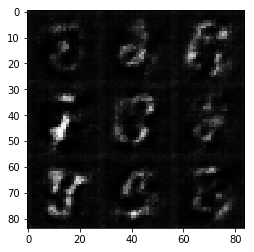

Epoch:0... Batch: 126... Discriminator Loss: 1.3074... Generator Loss: 0.8606
Epoch:0... Batch: 127... Discriminator Loss: 1.1892... Generator Loss: 1.1495
Epoch:0... Batch: 128... Discriminator Loss: 1.3552... Generator Loss: 0.5294
Epoch:0... Batch: 129... Discriminator Loss: 1.3361... Generator Loss: 1.5257
Epoch:0... Batch: 130... Discriminator Loss: 1.4662... Generator Loss: 0.3644
Epoch:0... Batch: 131... Discriminator Loss: 1.4846... Generator Loss: 1.6772
Epoch:0... Batch: 132... Discriminator Loss: 1.3886... Generator Loss: 0.5936
Epoch:0... Batch: 133... Discriminator Loss: 1.2783... Generator Loss: 1.1660
Epoch:0... Batch: 134... Discriminator Loss: 1.2414... Generator Loss: 0.7854
Epoch:0... Batch: 135... Discriminator Loss: 1.2396... Generator Loss: 0.9813
Epoch:0... Batch: 136... Discriminator Loss: 1.2560... Generator Loss: 0.8520
Epoch:0... Batch: 137... Discriminator Loss: 1.2431... Generator Loss: 0.9726
Epoch:0... Batch: 138... Discriminator Loss: 1.2905... Generator

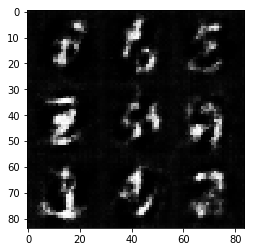

Epoch:0... Batch: 151... Discriminator Loss: 1.3476... Generator Loss: 1.5280
Epoch:0... Batch: 152... Discriminator Loss: 1.4310... Generator Loss: 0.4270
Epoch:0... Batch: 153... Discriminator Loss: 1.3678... Generator Loss: 1.4431
Epoch:0... Batch: 154... Discriminator Loss: 1.2368... Generator Loss: 0.7558
Epoch:0... Batch: 155... Discriminator Loss: 1.1678... Generator Loss: 1.0757
Epoch:0... Batch: 156... Discriminator Loss: 1.2409... Generator Loss: 0.9233
Epoch:0... Batch: 157... Discriminator Loss: 1.2819... Generator Loss: 0.8983
Epoch:0... Batch: 158... Discriminator Loss: 1.1654... Generator Loss: 1.0826
Epoch:0... Batch: 159... Discriminator Loss: 1.3483... Generator Loss: 0.5825
Epoch:0... Batch: 160... Discriminator Loss: 1.2629... Generator Loss: 1.5776
Epoch:0... Batch: 161... Discriminator Loss: 1.4414... Generator Loss: 0.4359
Epoch:0... Batch: 162... Discriminator Loss: 1.3739... Generator Loss: 1.6484
Epoch:0... Batch: 163... Discriminator Loss: 1.3928... Generator

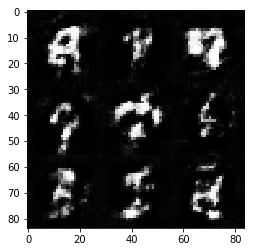

Epoch:0... Batch: 176... Discriminator Loss: 1.1199... Generator Loss: 1.1598
Epoch:0... Batch: 177... Discriminator Loss: 1.1124... Generator Loss: 0.9340
Epoch:0... Batch: 178... Discriminator Loss: 1.1771... Generator Loss: 0.9592
Epoch:0... Batch: 179... Discriminator Loss: 1.1337... Generator Loss: 1.0816
Epoch:0... Batch: 180... Discriminator Loss: 1.1359... Generator Loss: 0.8343
Epoch:0... Batch: 181... Discriminator Loss: 1.1994... Generator Loss: 1.1689
Epoch:0... Batch: 182... Discriminator Loss: 1.2571... Generator Loss: 0.8497
Epoch:0... Batch: 183... Discriminator Loss: 1.0913... Generator Loss: 0.9807
Epoch:0... Batch: 184... Discriminator Loss: 1.1979... Generator Loss: 0.8790
Epoch:0... Batch: 185... Discriminator Loss: 1.1554... Generator Loss: 1.0211
Epoch:0... Batch: 186... Discriminator Loss: 1.0565... Generator Loss: 0.9611
Epoch:0... Batch: 187... Discriminator Loss: 1.0847... Generator Loss: 1.2651
Epoch:0... Batch: 188... Discriminator Loss: 1.2322... Generator

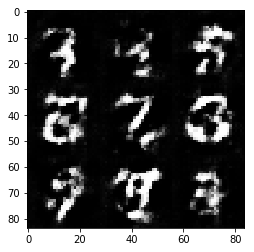

Epoch:0... Batch: 201... Discriminator Loss: 1.1775... Generator Loss: 1.1407
Epoch:0... Batch: 202... Discriminator Loss: 1.2228... Generator Loss: 0.8784
Epoch:0... Batch: 203... Discriminator Loss: 1.0983... Generator Loss: 1.2971
Epoch:0... Batch: 204... Discriminator Loss: 1.1122... Generator Loss: 0.7115
Epoch:0... Batch: 205... Discriminator Loss: 1.1814... Generator Loss: 1.4383
Epoch:0... Batch: 206... Discriminator Loss: 1.2958... Generator Loss: 0.5521
Epoch:0... Batch: 207... Discriminator Loss: 1.1937... Generator Loss: 1.6761
Epoch:0... Batch: 208... Discriminator Loss: 1.2384... Generator Loss: 0.6050
Epoch:0... Batch: 209... Discriminator Loss: 1.1257... Generator Loss: 1.6077
Epoch:0... Batch: 210... Discriminator Loss: 1.2448... Generator Loss: 0.6538
Epoch:0... Batch: 211... Discriminator Loss: 1.1160... Generator Loss: 1.1040
Epoch:0... Batch: 212... Discriminator Loss: 1.0972... Generator Loss: 1.2144
Epoch:0... Batch: 213... Discriminator Loss: 1.2382... Generator

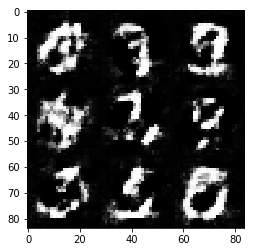

Epoch:0... Batch: 226... Discriminator Loss: 1.1329... Generator Loss: 1.3062
Epoch:0... Batch: 227... Discriminator Loss: 1.1393... Generator Loss: 0.9876
Epoch:0... Batch: 228... Discriminator Loss: 1.0434... Generator Loss: 0.9229
Epoch:0... Batch: 229... Discriminator Loss: 1.0721... Generator Loss: 1.2481
Epoch:0... Batch: 230... Discriminator Loss: 1.2616... Generator Loss: 0.6174
Epoch:0... Batch: 231... Discriminator Loss: 1.1655... Generator Loss: 1.8473
Epoch:0... Batch: 232... Discriminator Loss: 1.2704... Generator Loss: 0.5692
Epoch:0... Batch: 233... Discriminator Loss: 1.2000... Generator Loss: 1.5125
Epoch:0... Batch: 234... Discriminator Loss: 1.2298... Generator Loss: 0.7212
Epoch:0... Batch: 235... Discriminator Loss: 1.1305... Generator Loss: 1.4551
Epoch:0... Batch: 236... Discriminator Loss: 1.1679... Generator Loss: 0.6694
Epoch:0... Batch: 237... Discriminator Loss: 1.2139... Generator Loss: 1.4248
Epoch:0... Batch: 238... Discriminator Loss: 1.0753... Generator

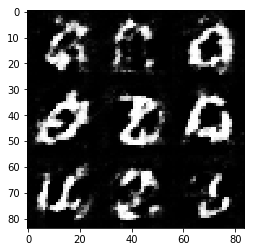

Epoch:0... Batch: 251... Discriminator Loss: 1.1855... Generator Loss: 1.4087
Epoch:0... Batch: 252... Discriminator Loss: 1.1280... Generator Loss: 0.7447
Epoch:0... Batch: 253... Discriminator Loss: 1.0721... Generator Loss: 1.4942
Epoch:0... Batch: 254... Discriminator Loss: 1.1813... Generator Loss: 0.6606
Epoch:0... Batch: 255... Discriminator Loss: 1.1942... Generator Loss: 1.7080
Epoch:0... Batch: 256... Discriminator Loss: 1.2220... Generator Loss: 0.5794
Epoch:0... Batch: 257... Discriminator Loss: 1.2016... Generator Loss: 1.5342
Epoch:0... Batch: 258... Discriminator Loss: 1.0608... Generator Loss: 1.2400
Epoch:0... Batch: 259... Discriminator Loss: 1.2353... Generator Loss: 0.6565
Epoch:0... Batch: 260... Discriminator Loss: 1.1347... Generator Loss: 1.6248
Epoch:0... Batch: 261... Discriminator Loss: 1.1844... Generator Loss: 0.7469
Epoch:0... Batch: 262... Discriminator Loss: 1.1471... Generator Loss: 1.2029
Epoch:0... Batch: 263... Discriminator Loss: 1.2149... Generator

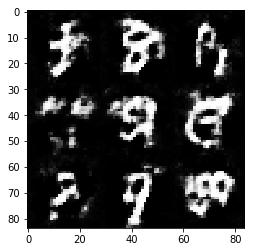

Epoch:0... Batch: 276... Discriminator Loss: 1.1064... Generator Loss: 1.1847
Epoch:0... Batch: 277... Discriminator Loss: 1.1920... Generator Loss: 1.0419
Epoch:0... Batch: 278... Discriminator Loss: 1.1679... Generator Loss: 1.0029
Epoch:0... Batch: 279... Discriminator Loss: 1.1546... Generator Loss: 0.9289
Epoch:0... Batch: 280... Discriminator Loss: 1.1302... Generator Loss: 1.0863
Epoch:0... Batch: 281... Discriminator Loss: 1.1023... Generator Loss: 1.2107
Epoch:0... Batch: 282... Discriminator Loss: 1.0677... Generator Loss: 1.0565
Epoch:0... Batch: 283... Discriminator Loss: 1.1705... Generator Loss: 0.7799
Epoch:0... Batch: 284... Discriminator Loss: 1.1182... Generator Loss: 1.6665
Epoch:0... Batch: 285... Discriminator Loss: 1.3411... Generator Loss: 0.3980
Epoch:0... Batch: 286... Discriminator Loss: 1.3083... Generator Loss: 2.2540
Epoch:0... Batch: 287... Discriminator Loss: 1.6182... Generator Loss: 0.3018
Epoch:0... Batch: 288... Discriminator Loss: 1.5683... Generator

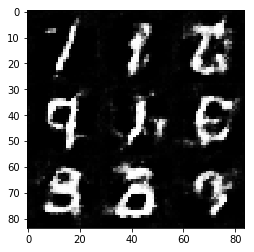

Epoch:0... Batch: 301... Discriminator Loss: 1.1297... Generator Loss: 0.7628
Epoch:0... Batch: 302... Discriminator Loss: 1.1798... Generator Loss: 1.5196
Epoch:0... Batch: 303... Discriminator Loss: 1.2795... Generator Loss: 0.5320
Epoch:0... Batch: 304... Discriminator Loss: 1.1511... Generator Loss: 1.7960
Epoch:0... Batch: 305... Discriminator Loss: 1.3524... Generator Loss: 0.4788
Epoch:0... Batch: 306... Discriminator Loss: 1.3042... Generator Loss: 1.9578
Epoch:0... Batch: 307... Discriminator Loss: 1.6100... Generator Loss: 0.3784
Epoch:0... Batch: 308... Discriminator Loss: 1.3768... Generator Loss: 1.6803
Epoch:0... Batch: 309... Discriminator Loss: 1.3933... Generator Loss: 0.6564
Epoch:0... Batch: 310... Discriminator Loss: 1.1728... Generator Loss: 1.0953
Epoch:0... Batch: 311... Discriminator Loss: 1.2250... Generator Loss: 1.1365
Epoch:0... Batch: 312... Discriminator Loss: 1.2906... Generator Loss: 0.6414
Epoch:0... Batch: 313... Discriminator Loss: 1.1998... Generator

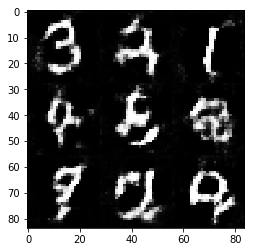

Epoch:0... Batch: 326... Discriminator Loss: 1.1695... Generator Loss: 1.1816
Epoch:0... Batch: 327... Discriminator Loss: 1.1934... Generator Loss: 0.8116
Epoch:0... Batch: 328... Discriminator Loss: 1.3166... Generator Loss: 1.1895
Epoch:0... Batch: 329... Discriminator Loss: 1.2062... Generator Loss: 0.8434
Epoch:0... Batch: 330... Discriminator Loss: 1.2083... Generator Loss: 1.2267
Epoch:0... Batch: 331... Discriminator Loss: 1.3069... Generator Loss: 0.6725
Epoch:0... Batch: 332... Discriminator Loss: 1.2625... Generator Loss: 1.4281
Epoch:0... Batch: 333... Discriminator Loss: 1.1912... Generator Loss: 0.7056
Epoch:0... Batch: 334... Discriminator Loss: 1.2384... Generator Loss: 1.4006
Epoch:0... Batch: 335... Discriminator Loss: 1.2649... Generator Loss: 0.6173
Epoch:0... Batch: 336... Discriminator Loss: 1.2420... Generator Loss: 1.6996
Epoch:0... Batch: 337... Discriminator Loss: 1.3136... Generator Loss: 0.5501
Epoch:0... Batch: 338... Discriminator Loss: 1.2668... Generator

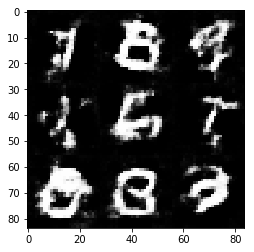

Epoch:0... Batch: 351... Discriminator Loss: 1.1716... Generator Loss: 1.0224
Epoch:0... Batch: 352... Discriminator Loss: 1.1300... Generator Loss: 1.0316
Epoch:0... Batch: 353... Discriminator Loss: 1.1534... Generator Loss: 0.8603
Epoch:0... Batch: 354... Discriminator Loss: 1.2558... Generator Loss: 1.3083
Epoch:0... Batch: 355... Discriminator Loss: 1.3368... Generator Loss: 0.5015
Epoch:0... Batch: 356... Discriminator Loss: 1.3107... Generator Loss: 1.7205
Epoch:0... Batch: 357... Discriminator Loss: 1.4240... Generator Loss: 0.5348
Epoch:0... Batch: 358... Discriminator Loss: 1.3174... Generator Loss: 1.3834
Epoch:0... Batch: 359... Discriminator Loss: 1.3685... Generator Loss: 0.6848
Epoch:0... Batch: 360... Discriminator Loss: 1.1782... Generator Loss: 1.2008
Epoch:0... Batch: 361... Discriminator Loss: 1.2443... Generator Loss: 0.7874
Epoch:0... Batch: 362... Discriminator Loss: 1.2308... Generator Loss: 1.3525
Epoch:0... Batch: 363... Discriminator Loss: 1.3510... Generator

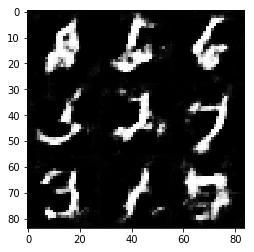

Epoch:0... Batch: 376... Discriminator Loss: 1.2145... Generator Loss: 0.9236
Epoch:0... Batch: 377... Discriminator Loss: 1.2391... Generator Loss: 0.9012
Epoch:0... Batch: 378... Discriminator Loss: 1.3054... Generator Loss: 1.1591
Epoch:0... Batch: 379... Discriminator Loss: 1.3394... Generator Loss: 0.6802
Epoch:0... Batch: 380... Discriminator Loss: 1.2607... Generator Loss: 1.3060
Epoch:0... Batch: 381... Discriminator Loss: 1.2470... Generator Loss: 0.9127
Epoch:0... Batch: 382... Discriminator Loss: 1.2132... Generator Loss: 1.2403
Epoch:0... Batch: 383... Discriminator Loss: 1.2192... Generator Loss: 0.6704
Epoch:0... Batch: 384... Discriminator Loss: 1.1965... Generator Loss: 1.7585
Epoch:0... Batch: 385... Discriminator Loss: 1.4415... Generator Loss: 0.3886
Epoch:0... Batch: 386... Discriminator Loss: 1.3945... Generator Loss: 1.6563
Epoch:0... Batch: 387... Discriminator Loss: 1.4664... Generator Loss: 0.6025
Epoch:0... Batch: 388... Discriminator Loss: 1.2138... Generator

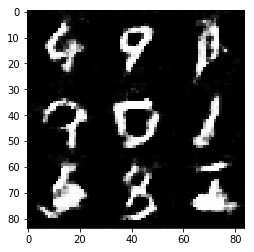

Epoch:0... Batch: 401... Discriminator Loss: 1.3397... Generator Loss: 1.7253
Epoch:0... Batch: 402... Discriminator Loss: 1.4215... Generator Loss: 0.5418
Epoch:0... Batch: 403... Discriminator Loss: 1.3221... Generator Loss: 1.4785
Epoch:0... Batch: 404... Discriminator Loss: 1.4554... Generator Loss: 0.7084
Epoch:0... Batch: 405... Discriminator Loss: 1.2232... Generator Loss: 1.0938
Epoch:0... Batch: 406... Discriminator Loss: 1.1840... Generator Loss: 0.9503
Epoch:0... Batch: 407... Discriminator Loss: 1.2609... Generator Loss: 0.9766
Epoch:0... Batch: 408... Discriminator Loss: 1.2582... Generator Loss: 0.8629
Epoch:0... Batch: 409... Discriminator Loss: 1.2406... Generator Loss: 1.0138
Epoch:0... Batch: 410... Discriminator Loss: 1.1432... Generator Loss: 0.9778
Epoch:0... Batch: 411... Discriminator Loss: 1.2400... Generator Loss: 0.8422
Epoch:0... Batch: 412... Discriminator Loss: 1.2762... Generator Loss: 1.0876
Epoch:0... Batch: 413... Discriminator Loss: 1.2018... Generator

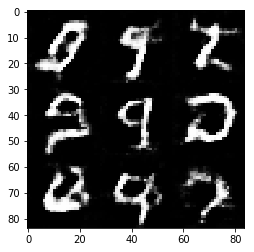

Epoch:0... Batch: 426... Discriminator Loss: 1.3295... Generator Loss: 0.8461
Epoch:0... Batch: 427... Discriminator Loss: 1.2410... Generator Loss: 1.1271
Epoch:0... Batch: 428... Discriminator Loss: 1.2426... Generator Loss: 0.7040
Epoch:0... Batch: 429... Discriminator Loss: 1.3207... Generator Loss: 1.2662
Epoch:0... Batch: 430... Discriminator Loss: 1.3223... Generator Loss: 0.7181
Epoch:0... Batch: 431... Discriminator Loss: 1.1815... Generator Loss: 1.1873
Epoch:0... Batch: 432... Discriminator Loss: 1.2524... Generator Loss: 0.7775
Epoch:0... Batch: 433... Discriminator Loss: 1.2795... Generator Loss: 1.0738
Epoch:0... Batch: 434... Discriminator Loss: 1.2189... Generator Loss: 0.9131
Epoch:0... Batch: 435... Discriminator Loss: 1.2009... Generator Loss: 1.0670
Epoch:0... Batch: 436... Discriminator Loss: 1.2139... Generator Loss: 0.8431
Epoch:0... Batch: 437... Discriminator Loss: 1.2092... Generator Loss: 1.0338
Epoch:0... Batch: 438... Discriminator Loss: 1.1890... Generator

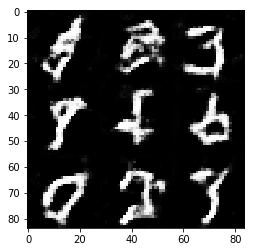

Epoch:0... Batch: 451... Discriminator Loss: 1.2674... Generator Loss: 0.8976
Epoch:0... Batch: 452... Discriminator Loss: 1.2511... Generator Loss: 0.8389
Epoch:0... Batch: 453... Discriminator Loss: 1.1264... Generator Loss: 1.3047
Epoch:0... Batch: 454... Discriminator Loss: 1.2924... Generator Loss: 0.6085
Epoch:0... Batch: 455... Discriminator Loss: 1.2358... Generator Loss: 1.4266
Epoch:0... Batch: 456... Discriminator Loss: 1.3560... Generator Loss: 0.5792
Epoch:0... Batch: 457... Discriminator Loss: 1.2477... Generator Loss: 1.4627
Epoch:0... Batch: 458... Discriminator Loss: 1.3528... Generator Loss: 0.6327
Epoch:0... Batch: 459... Discriminator Loss: 1.2041... Generator Loss: 1.2835
Epoch:0... Batch: 460... Discriminator Loss: 1.2153... Generator Loss: 0.8513
Epoch:0... Batch: 461... Discriminator Loss: 1.2104... Generator Loss: 1.1044
Epoch:0... Batch: 462... Discriminator Loss: 1.2221... Generator Loss: 0.9709
Epoch:0... Batch: 463... Discriminator Loss: 1.2065... Generator

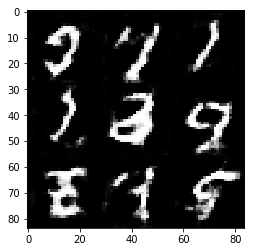

Epoch:0... Batch: 476... Discriminator Loss: 1.3296... Generator Loss: 0.4914
Epoch:0... Batch: 477... Discriminator Loss: 1.2798... Generator Loss: 1.8981
Epoch:0... Batch: 478... Discriminator Loss: 1.4707... Generator Loss: 0.3753
Epoch:0... Batch: 479... Discriminator Loss: 1.4901... Generator Loss: 1.7252
Epoch:0... Batch: 480... Discriminator Loss: 1.3980... Generator Loss: 0.7404
Epoch:0... Batch: 481... Discriminator Loss: 1.1923... Generator Loss: 1.0761
Epoch:0... Batch: 482... Discriminator Loss: 1.2053... Generator Loss: 0.9333
Epoch:0... Batch: 483... Discriminator Loss: 1.1294... Generator Loss: 1.0798
Epoch:0... Batch: 484... Discriminator Loss: 1.2288... Generator Loss: 0.8773
Epoch:0... Batch: 485... Discriminator Loss: 1.1935... Generator Loss: 0.9784
Epoch:0... Batch: 486... Discriminator Loss: 1.1611... Generator Loss: 0.9748
Epoch:0... Batch: 487... Discriminator Loss: 1.2674... Generator Loss: 0.9437
Epoch:0... Batch: 488... Discriminator Loss: 1.1631... Generator

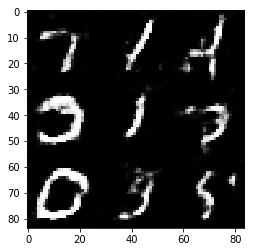

Epoch:0... Batch: 501... Discriminator Loss: 1.3380... Generator Loss: 0.6694
Epoch:0... Batch: 502... Discriminator Loss: 1.2470... Generator Loss: 1.2604
Epoch:0... Batch: 503... Discriminator Loss: 1.2363... Generator Loss: 0.7320
Epoch:0... Batch: 504... Discriminator Loss: 1.2697... Generator Loss: 1.3214
Epoch:0... Batch: 505... Discriminator Loss: 1.2712... Generator Loss: 0.7996
Epoch:0... Batch: 506... Discriminator Loss: 1.1801... Generator Loss: 0.8536
Epoch:0... Batch: 507... Discriminator Loss: 1.1498... Generator Loss: 1.2952
Epoch:0... Batch: 508... Discriminator Loss: 1.3359... Generator Loss: 0.6641
Epoch:0... Batch: 509... Discriminator Loss: 1.2171... Generator Loss: 1.4323
Epoch:0... Batch: 510... Discriminator Loss: 1.3835... Generator Loss: 0.4928
Epoch:0... Batch: 511... Discriminator Loss: 1.3475... Generator Loss: 1.6424
Epoch:0... Batch: 512... Discriminator Loss: 1.3041... Generator Loss: 0.6634
Epoch:0... Batch: 513... Discriminator Loss: 1.2617... Generator

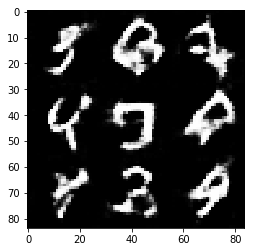

Epoch:0... Batch: 526... Discriminator Loss: 1.2974... Generator Loss: 1.3170
Epoch:0... Batch: 527... Discriminator Loss: 1.2852... Generator Loss: 0.4814
Epoch:0... Batch: 528... Discriminator Loss: 1.4273... Generator Loss: 1.8952
Epoch:0... Batch: 529... Discriminator Loss: 1.5313... Generator Loss: 0.3414
Epoch:0... Batch: 530... Discriminator Loss: 1.4652... Generator Loss: 1.9046
Epoch:0... Batch: 531... Discriminator Loss: 1.4661... Generator Loss: 0.7089
Epoch:0... Batch: 532... Discriminator Loss: 1.2528... Generator Loss: 1.0331
Epoch:0... Batch: 533... Discriminator Loss: 1.1429... Generator Loss: 1.0597
Epoch:0... Batch: 534... Discriminator Loss: 1.2954... Generator Loss: 0.8592
Epoch:0... Batch: 535... Discriminator Loss: 1.2388... Generator Loss: 1.0699
Epoch:0... Batch: 536... Discriminator Loss: 1.2402... Generator Loss: 0.9057
Epoch:0... Batch: 537... Discriminator Loss: 1.2644... Generator Loss: 1.1393
Epoch:0... Batch: 538... Discriminator Loss: 1.3483... Generator

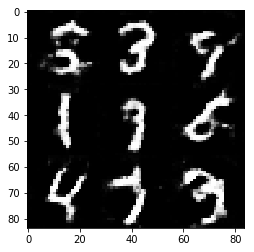

Epoch:0... Batch: 551... Discriminator Loss: 1.1773... Generator Loss: 1.1750
Epoch:0... Batch: 552... Discriminator Loss: 1.2651... Generator Loss: 0.7548
Epoch:0... Batch: 553... Discriminator Loss: 1.2278... Generator Loss: 1.0535
Epoch:0... Batch: 554... Discriminator Loss: 1.2262... Generator Loss: 0.9805
Epoch:0... Batch: 555... Discriminator Loss: 1.2667... Generator Loss: 1.0039
Epoch:0... Batch: 556... Discriminator Loss: 1.3438... Generator Loss: 0.7209
Epoch:0... Batch: 557... Discriminator Loss: 1.3101... Generator Loss: 1.4889
Epoch:0... Batch: 558... Discriminator Loss: 1.4850... Generator Loss: 0.4108
Epoch:0... Batch: 559... Discriminator Loss: 1.4317... Generator Loss: 1.7923
Epoch:0... Batch: 560... Discriminator Loss: 1.5337... Generator Loss: 0.4252
Epoch:0... Batch: 561... Discriminator Loss: 1.3480... Generator Loss: 1.5569
Epoch:0... Batch: 562... Discriminator Loss: 1.2594... Generator Loss: 0.8132
Epoch:0... Batch: 563... Discriminator Loss: 1.1327... Generator

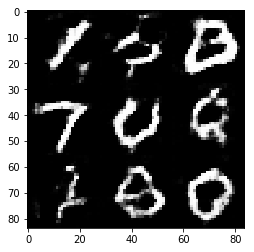

Epoch:0... Batch: 576... Discriminator Loss: 1.2708... Generator Loss: 1.1784
Epoch:0... Batch: 577... Discriminator Loss: 1.2848... Generator Loss: 0.8273
Epoch:0... Batch: 578... Discriminator Loss: 1.2250... Generator Loss: 1.0753
Epoch:0... Batch: 579... Discriminator Loss: 1.2812... Generator Loss: 1.0800
Epoch:0... Batch: 580... Discriminator Loss: 1.2143... Generator Loss: 0.8072
Epoch:0... Batch: 581... Discriminator Loss: 1.2152... Generator Loss: 1.1481
Epoch:0... Batch: 582... Discriminator Loss: 1.2246... Generator Loss: 0.7642
Epoch:0... Batch: 583... Discriminator Loss: 1.1992... Generator Loss: 1.2759
Epoch:0... Batch: 584... Discriminator Loss: 1.2865... Generator Loss: 0.5924
Epoch:0... Batch: 585... Discriminator Loss: 1.2987... Generator Loss: 1.5375
Epoch:0... Batch: 586... Discriminator Loss: 1.3218... Generator Loss: 0.5363
Epoch:0... Batch: 587... Discriminator Loss: 1.3403... Generator Loss: 1.7959
Epoch:0... Batch: 588... Discriminator Loss: 1.4423... Generator

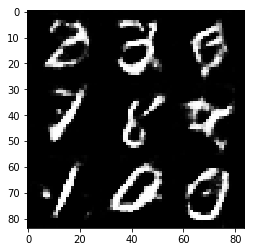

Epoch:0... Batch: 601... Discriminator Loss: 1.3562... Generator Loss: 0.7664
Epoch:0... Batch: 602... Discriminator Loss: 1.2257... Generator Loss: 1.1610
Epoch:0... Batch: 603... Discriminator Loss: 1.1720... Generator Loss: 0.7425
Epoch:0... Batch: 604... Discriminator Loss: 1.1595... Generator Loss: 1.2079
Epoch:0... Batch: 605... Discriminator Loss: 1.2473... Generator Loss: 0.7907
Epoch:0... Batch: 606... Discriminator Loss: 1.2699... Generator Loss: 1.0032
Epoch:0... Batch: 607... Discriminator Loss: 1.2511... Generator Loss: 1.0463
Epoch:0... Batch: 608... Discriminator Loss: 1.1465... Generator Loss: 0.8996
Epoch:0... Batch: 609... Discriminator Loss: 1.2283... Generator Loss: 1.0729
Epoch:0... Batch: 610... Discriminator Loss: 1.1569... Generator Loss: 0.9325
Epoch:0... Batch: 611... Discriminator Loss: 1.1266... Generator Loss: 1.0810
Epoch:0... Batch: 612... Discriminator Loss: 1.1627... Generator Loss: 1.3268
Epoch:0... Batch: 613... Discriminator Loss: 1.2868... Generator

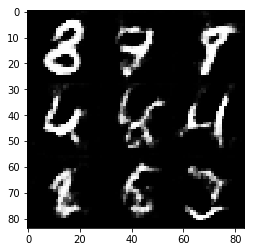

Epoch:0... Batch: 626... Discriminator Loss: 1.2906... Generator Loss: 0.7604
Epoch:0... Batch: 627... Discriminator Loss: 1.2396... Generator Loss: 1.3169
Epoch:0... Batch: 628... Discriminator Loss: 1.3060... Generator Loss: 0.8492
Epoch:0... Batch: 629... Discriminator Loss: 1.2356... Generator Loss: 1.0007
Epoch:0... Batch: 630... Discriminator Loss: 1.1904... Generator Loss: 1.0688
Epoch:0... Batch: 631... Discriminator Loss: 1.2325... Generator Loss: 0.7950
Epoch:0... Batch: 632... Discriminator Loss: 1.2214... Generator Loss: 1.4490
Epoch:0... Batch: 633... Discriminator Loss: 1.2856... Generator Loss: 0.6529
Epoch:0... Batch: 634... Discriminator Loss: 1.2802... Generator Loss: 1.3195
Epoch:0... Batch: 635... Discriminator Loss: 1.2079... Generator Loss: 0.8607
Epoch:0... Batch: 636... Discriminator Loss: 1.1697... Generator Loss: 1.0342
Epoch:0... Batch: 637... Discriminator Loss: 1.1407... Generator Loss: 1.0882
Epoch:0... Batch: 638... Discriminator Loss: 1.2850... Generator

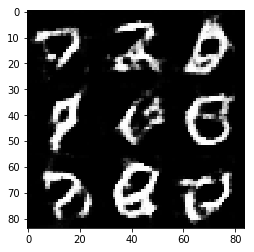

Epoch:0... Batch: 651... Discriminator Loss: 1.1489... Generator Loss: 1.1547
Epoch:0... Batch: 652... Discriminator Loss: 1.2575... Generator Loss: 0.5845
Epoch:0... Batch: 653... Discriminator Loss: 1.2870... Generator Loss: 1.4907
Epoch:0... Batch: 654... Discriminator Loss: 1.3061... Generator Loss: 0.5973
Epoch:0... Batch: 655... Discriminator Loss: 1.3555... Generator Loss: 1.5900
Epoch:0... Batch: 656... Discriminator Loss: 1.3285... Generator Loss: 0.7628
Epoch:0... Batch: 657... Discriminator Loss: 1.2738... Generator Loss: 0.9889
Epoch:0... Batch: 658... Discriminator Loss: 1.2719... Generator Loss: 1.2803
Epoch:0... Batch: 659... Discriminator Loss: 1.1800... Generator Loss: 0.8577
Epoch:0... Batch: 660... Discriminator Loss: 1.2232... Generator Loss: 0.9779
Epoch:0... Batch: 661... Discriminator Loss: 1.1712... Generator Loss: 1.3904
Epoch:0... Batch: 662... Discriminator Loss: 1.2054... Generator Loss: 0.6475
Epoch:0... Batch: 663... Discriminator Loss: 1.2437... Generator

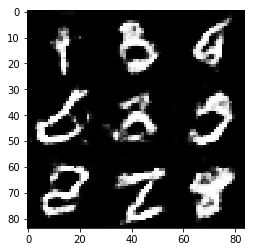

Epoch:0... Batch: 676... Discriminator Loss: 1.1957... Generator Loss: 0.7247
Epoch:0... Batch: 677... Discriminator Loss: 1.1296... Generator Loss: 1.2856
Epoch:0... Batch: 678... Discriminator Loss: 1.1409... Generator Loss: 0.8509
Epoch:0... Batch: 679... Discriminator Loss: 1.1472... Generator Loss: 1.1161
Epoch:0... Batch: 680... Discriminator Loss: 1.1745... Generator Loss: 0.9759
Epoch:0... Batch: 681... Discriminator Loss: 1.2575... Generator Loss: 1.0577
Epoch:0... Batch: 682... Discriminator Loss: 1.2229... Generator Loss: 1.0874
Epoch:0... Batch: 683... Discriminator Loss: 1.4035... Generator Loss: 0.5970
Epoch:0... Batch: 684... Discriminator Loss: 1.2132... Generator Loss: 1.8451
Epoch:0... Batch: 685... Discriminator Loss: 1.4313... Generator Loss: 0.3872
Epoch:0... Batch: 686... Discriminator Loss: 1.4246... Generator Loss: 1.7971
Epoch:0... Batch: 687... Discriminator Loss: 1.2079... Generator Loss: 0.7736
Epoch:0... Batch: 688... Discriminator Loss: 1.1978... Generator

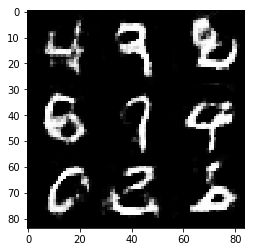

Epoch:0... Batch: 701... Discriminator Loss: 1.3044... Generator Loss: 0.7438
Epoch:0... Batch: 702... Discriminator Loss: 1.2831... Generator Loss: 1.0243
Epoch:0... Batch: 703... Discriminator Loss: 1.1472... Generator Loss: 1.0343
Epoch:0... Batch: 704... Discriminator Loss: 1.1771... Generator Loss: 1.2241
Epoch:0... Batch: 705... Discriminator Loss: 1.2374... Generator Loss: 0.6450
Epoch:0... Batch: 706... Discriminator Loss: 1.2116... Generator Loss: 1.4189
Epoch:0... Batch: 707... Discriminator Loss: 1.2634... Generator Loss: 0.6469
Epoch:0... Batch: 708... Discriminator Loss: 1.2560... Generator Loss: 1.5561
Epoch:0... Batch: 709... Discriminator Loss: 1.2406... Generator Loss: 0.7131
Epoch:0... Batch: 710... Discriminator Loss: 1.1354... Generator Loss: 1.2726
Epoch:0... Batch: 711... Discriminator Loss: 1.1941... Generator Loss: 0.9278
Epoch:0... Batch: 712... Discriminator Loss: 1.1679... Generator Loss: 1.3095
Epoch:0... Batch: 713... Discriminator Loss: 1.2430... Generator

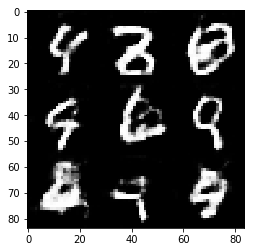

Epoch:0... Batch: 726... Discriminator Loss: 1.2915... Generator Loss: 0.5295
Epoch:0... Batch: 727... Discriminator Loss: 1.3516... Generator Loss: 1.7305
Epoch:0... Batch: 728... Discriminator Loss: 1.4007... Generator Loss: 0.5765
Epoch:0... Batch: 729... Discriminator Loss: 1.2354... Generator Loss: 1.3499
Epoch:0... Batch: 730... Discriminator Loss: 1.1542... Generator Loss: 0.9951
Epoch:0... Batch: 731... Discriminator Loss: 1.1657... Generator Loss: 0.9413
Epoch:0... Batch: 732... Discriminator Loss: 1.1728... Generator Loss: 1.1996
Epoch:0... Batch: 733... Discriminator Loss: 1.1639... Generator Loss: 0.9097
Epoch:0... Batch: 734... Discriminator Loss: 1.1579... Generator Loss: 1.1727
Epoch:0... Batch: 735... Discriminator Loss: 1.2947... Generator Loss: 0.6989
Epoch:0... Batch: 736... Discriminator Loss: 1.2625... Generator Loss: 1.5354
Epoch:0... Batch: 737... Discriminator Loss: 1.2274... Generator Loss: 0.6099
Epoch:0... Batch: 738... Discriminator Loss: 1.2020... Generator

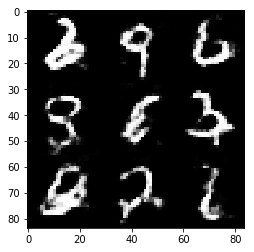

Epoch:0... Batch: 751... Discriminator Loss: 1.1944... Generator Loss: 0.8186
Epoch:0... Batch: 752... Discriminator Loss: 1.1582... Generator Loss: 1.3051
Epoch:0... Batch: 753... Discriminator Loss: 1.2560... Generator Loss: 0.6996
Epoch:0... Batch: 754... Discriminator Loss: 1.1215... Generator Loss: 1.3406
Epoch:0... Batch: 755... Discriminator Loss: 1.1378... Generator Loss: 0.8402
Epoch:0... Batch: 756... Discriminator Loss: 1.0402... Generator Loss: 1.4483
Epoch:0... Batch: 757... Discriminator Loss: 1.2216... Generator Loss: 0.7884
Epoch:0... Batch: 758... Discriminator Loss: 1.2313... Generator Loss: 1.2195
Epoch:0... Batch: 759... Discriminator Loss: 1.1983... Generator Loss: 0.8216
Epoch:0... Batch: 760... Discriminator Loss: 1.1490... Generator Loss: 1.3270
Epoch:0... Batch: 761... Discriminator Loss: 1.0841... Generator Loss: 0.9806
Epoch:0... Batch: 762... Discriminator Loss: 1.1268... Generator Loss: 1.3205
Epoch:0... Batch: 763... Discriminator Loss: 1.1700... Generator

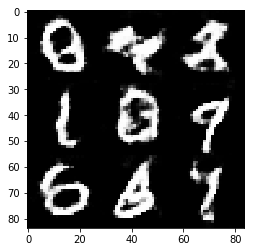

Epoch:0... Batch: 776... Discriminator Loss: 1.1468... Generator Loss: 0.9765
Epoch:0... Batch: 777... Discriminator Loss: 1.1645... Generator Loss: 1.3898
Epoch:0... Batch: 778... Discriminator Loss: 1.3173... Generator Loss: 0.6600
Epoch:0... Batch: 779... Discriminator Loss: 1.1474... Generator Loss: 1.2089
Epoch:0... Batch: 780... Discriminator Loss: 1.0269... Generator Loss: 1.2739
Epoch:0... Batch: 781... Discriminator Loss: 1.1931... Generator Loss: 0.8444
Epoch:0... Batch: 782... Discriminator Loss: 1.1323... Generator Loss: 1.1649
Epoch:0... Batch: 783... Discriminator Loss: 1.1628... Generator Loss: 1.2136
Epoch:0... Batch: 784... Discriminator Loss: 1.1976... Generator Loss: 0.7136
Epoch:0... Batch: 785... Discriminator Loss: 1.2098... Generator Loss: 1.5251
Epoch:0... Batch: 786... Discriminator Loss: 1.3126... Generator Loss: 0.5777
Epoch:0... Batch: 787... Discriminator Loss: 1.2048... Generator Loss: 1.5561
Epoch:0... Batch: 788... Discriminator Loss: 1.2243... Generator

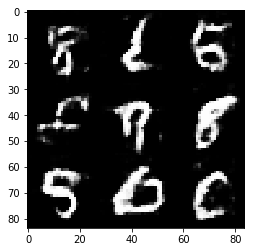

Epoch:0... Batch: 801... Discriminator Loss: 1.0949... Generator Loss: 1.0126
Epoch:0... Batch: 802... Discriminator Loss: 1.1310... Generator Loss: 1.1146
Epoch:0... Batch: 803... Discriminator Loss: 1.1442... Generator Loss: 0.8039
Epoch:0... Batch: 804... Discriminator Loss: 1.1797... Generator Loss: 1.3297
Epoch:0... Batch: 805... Discriminator Loss: 1.1256... Generator Loss: 0.9727
Epoch:0... Batch: 806... Discriminator Loss: 1.1270... Generator Loss: 1.0103
Epoch:0... Batch: 807... Discriminator Loss: 1.0578... Generator Loss: 1.1655
Epoch:0... Batch: 808... Discriminator Loss: 1.0589... Generator Loss: 1.4326
Epoch:0... Batch: 809... Discriminator Loss: 1.3416... Generator Loss: 0.4036
Epoch:0... Batch: 810... Discriminator Loss: 1.3603... Generator Loss: 2.2858
Epoch:0... Batch: 811... Discriminator Loss: 1.4086... Generator Loss: 0.4408
Epoch:0... Batch: 812... Discriminator Loss: 1.2871... Generator Loss: 1.7104
Epoch:0... Batch: 813... Discriminator Loss: 1.2482... Generator

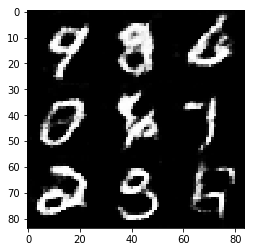

Epoch:0... Batch: 826... Discriminator Loss: 1.1953... Generator Loss: 0.8314
Epoch:0... Batch: 827... Discriminator Loss: 1.1431... Generator Loss: 1.0192
Epoch:0... Batch: 828... Discriminator Loss: 1.1906... Generator Loss: 1.2508
Epoch:0... Batch: 829... Discriminator Loss: 1.2658... Generator Loss: 0.5228
Epoch:0... Batch: 830... Discriminator Loss: 1.2872... Generator Loss: 2.1546
Epoch:0... Batch: 831... Discriminator Loss: 1.6814... Generator Loss: 0.2945
Epoch:0... Batch: 832... Discriminator Loss: 1.5157... Generator Loss: 1.8667
Epoch:0... Batch: 833... Discriminator Loss: 1.1173... Generator Loss: 1.0821
Epoch:0... Batch: 834... Discriminator Loss: 1.1776... Generator Loss: 0.9143
Epoch:0... Batch: 835... Discriminator Loss: 1.2216... Generator Loss: 1.1758
Epoch:0... Batch: 836... Discriminator Loss: 1.1309... Generator Loss: 1.0598
Epoch:0... Batch: 837... Discriminator Loss: 1.0754... Generator Loss: 1.0495
Epoch:0... Batch: 838... Discriminator Loss: 1.0456... Generator

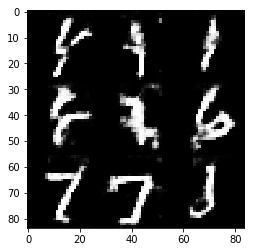

Epoch:0... Batch: 851... Discriminator Loss: 1.1028... Generator Loss: 1.4299
Epoch:0... Batch: 852... Discriminator Loss: 1.1253... Generator Loss: 0.8838
Epoch:0... Batch: 853... Discriminator Loss: 1.1890... Generator Loss: 1.2742
Epoch:0... Batch: 854... Discriminator Loss: 1.1589... Generator Loss: 0.8371
Epoch:0... Batch: 855... Discriminator Loss: 1.1983... Generator Loss: 1.9028
Epoch:0... Batch: 856... Discriminator Loss: 1.3801... Generator Loss: 0.3761
Epoch:0... Batch: 857... Discriminator Loss: 1.2901... Generator Loss: 2.3135
Epoch:0... Batch: 858... Discriminator Loss: 1.2796... Generator Loss: 0.5809
Epoch:0... Batch: 859... Discriminator Loss: 1.1694... Generator Loss: 1.6323
Epoch:0... Batch: 860... Discriminator Loss: 1.2477... Generator Loss: 0.9083
Epoch:0... Batch: 861... Discriminator Loss: 1.1160... Generator Loss: 1.0260
Epoch:0... Batch: 862... Discriminator Loss: 1.1200... Generator Loss: 1.2326
Epoch:0... Batch: 863... Discriminator Loss: 1.1492... Generator

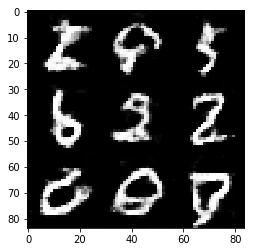

Epoch:0... Batch: 876... Discriminator Loss: 1.1092... Generator Loss: 1.0520
Epoch:0... Batch: 877... Discriminator Loss: 1.2200... Generator Loss: 0.8568
Epoch:0... Batch: 878... Discriminator Loss: 1.0790... Generator Loss: 1.3708
Epoch:0... Batch: 879... Discriminator Loss: 1.2224... Generator Loss: 0.7570
Epoch:0... Batch: 880... Discriminator Loss: 1.1243... Generator Loss: 1.4214
Epoch:0... Batch: 881... Discriminator Loss: 1.0758... Generator Loss: 0.8443
Epoch:0... Batch: 882... Discriminator Loss: 1.0617... Generator Loss: 1.8898
Epoch:0... Batch: 883... Discriminator Loss: 1.3442... Generator Loss: 0.3826
Epoch:0... Batch: 884... Discriminator Loss: 1.3988... Generator Loss: 2.1145
Epoch:0... Batch: 885... Discriminator Loss: 1.3566... Generator Loss: 0.6966
Epoch:0... Batch: 886... Discriminator Loss: 1.0761... Generator Loss: 1.2114
Epoch:0... Batch: 887... Discriminator Loss: 1.0168... Generator Loss: 1.1783
Epoch:0... Batch: 888... Discriminator Loss: 1.1402... Generator

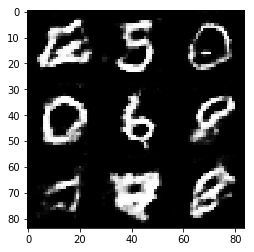

Epoch:0... Batch: 901... Discriminator Loss: 1.1177... Generator Loss: 0.9226
Epoch:0... Batch: 902... Discriminator Loss: 1.0937... Generator Loss: 1.4099
Epoch:0... Batch: 903... Discriminator Loss: 1.1428... Generator Loss: 0.6851
Epoch:0... Batch: 904... Discriminator Loss: 1.1673... Generator Loss: 1.4568
Epoch:0... Batch: 905... Discriminator Loss: 1.0765... Generator Loss: 0.9899
Epoch:0... Batch: 906... Discriminator Loss: 0.9882... Generator Loss: 1.2289
Epoch:0... Batch: 907... Discriminator Loss: 1.1918... Generator Loss: 1.1002
Epoch:0... Batch: 908... Discriminator Loss: 0.9539... Generator Loss: 1.1442
Epoch:0... Batch: 909... Discriminator Loss: 1.0006... Generator Loss: 1.1556
Epoch:0... Batch: 910... Discriminator Loss: 1.1247... Generator Loss: 1.1832
Epoch:0... Batch: 911... Discriminator Loss: 1.2363... Generator Loss: 0.8340
Epoch:0... Batch: 912... Discriminator Loss: 1.0966... Generator Loss: 1.2247
Epoch:0... Batch: 913... Discriminator Loss: 1.0845... Generator

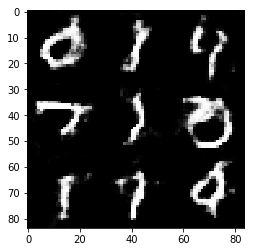

Epoch:0... Batch: 926... Discriminator Loss: 1.2365... Generator Loss: 0.4680
Epoch:0... Batch: 927... Discriminator Loss: 1.3036... Generator Loss: 2.1150
Epoch:0... Batch: 928... Discriminator Loss: 1.2902... Generator Loss: 0.6065
Epoch:0... Batch: 929... Discriminator Loss: 1.1683... Generator Loss: 1.6004
Epoch:0... Batch: 930... Discriminator Loss: 1.1427... Generator Loss: 0.7821
Epoch:0... Batch: 931... Discriminator Loss: 1.1253... Generator Loss: 1.7302
Epoch:0... Batch: 932... Discriminator Loss: 1.2350... Generator Loss: 0.7684
Epoch:0... Batch: 933... Discriminator Loss: 1.1353... Generator Loss: 1.3187
Epoch:0... Batch: 934... Discriminator Loss: 1.1626... Generator Loss: 1.0369
Epoch:0... Batch: 935... Discriminator Loss: 1.0974... Generator Loss: 0.8823
Epoch:0... Batch: 936... Discriminator Loss: 1.2054... Generator Loss: 1.5177
Epoch:0... Batch: 937... Discriminator Loss: 1.2275... Generator Loss: 0.7425
Epoch:1... Batch: 1... Discriminator Loss: 1.0822... Generator L

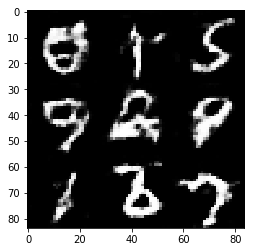

Epoch:1... Batch: 26... Discriminator Loss: 1.3146... Generator Loss: 0.4523
Epoch:1... Batch: 27... Discriminator Loss: 1.3180... Generator Loss: 1.8360
Epoch:1... Batch: 28... Discriminator Loss: 1.1310... Generator Loss: 0.8464
Epoch:1... Batch: 29... Discriminator Loss: 1.0583... Generator Loss: 1.0680
Epoch:1... Batch: 30... Discriminator Loss: 1.0018... Generator Loss: 1.4096
Epoch:1... Batch: 31... Discriminator Loss: 1.0780... Generator Loss: 0.7976
Epoch:1... Batch: 32... Discriminator Loss: 1.1074... Generator Loss: 1.7157
Epoch:1... Batch: 33... Discriminator Loss: 1.0948... Generator Loss: 0.9572
Epoch:1... Batch: 34... Discriminator Loss: 1.0268... Generator Loss: 1.0921
Epoch:1... Batch: 35... Discriminator Loss: 1.0758... Generator Loss: 1.2769
Epoch:1... Batch: 36... Discriminator Loss: 1.0630... Generator Loss: 0.7002
Epoch:1... Batch: 37... Discriminator Loss: 1.1166... Generator Loss: 1.9812
Epoch:1... Batch: 38... Discriminator Loss: 1.3077... Generator Loss: 0.4382

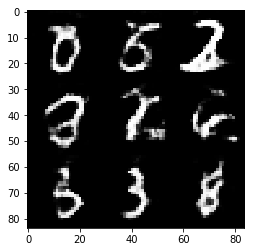

Epoch:1... Batch: 51... Discriminator Loss: 1.2582... Generator Loss: 2.2231
Epoch:1... Batch: 52... Discriminator Loss: 1.3609... Generator Loss: 0.6658
Epoch:1... Batch: 53... Discriminator Loss: 1.1596... Generator Loss: 1.6643
Epoch:1... Batch: 54... Discriminator Loss: 1.1268... Generator Loss: 0.8427
Epoch:1... Batch: 55... Discriminator Loss: 1.1493... Generator Loss: 1.2963
Epoch:1... Batch: 56... Discriminator Loss: 1.0079... Generator Loss: 1.0886
Epoch:1... Batch: 57... Discriminator Loss: 1.1017... Generator Loss: 1.1808
Epoch:1... Batch: 58... Discriminator Loss: 1.0370... Generator Loss: 1.0732
Epoch:1... Batch: 59... Discriminator Loss: 1.0370... Generator Loss: 1.3383
Epoch:1... Batch: 60... Discriminator Loss: 1.0387... Generator Loss: 0.9883
Epoch:1... Batch: 61... Discriminator Loss: 0.9838... Generator Loss: 1.2272
Epoch:1... Batch: 62... Discriminator Loss: 1.0473... Generator Loss: 0.9748
Epoch:1... Batch: 63... Discriminator Loss: 1.1380... Generator Loss: 1.1896

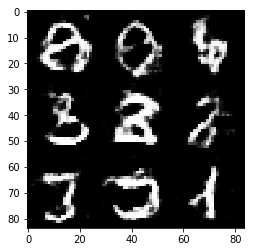

Epoch:1... Batch: 76... Discriminator Loss: 1.0654... Generator Loss: 1.1292
Epoch:1... Batch: 77... Discriminator Loss: 1.1288... Generator Loss: 0.6986
Epoch:1... Batch: 78... Discriminator Loss: 1.0024... Generator Loss: 2.2018
Epoch:1... Batch: 79... Discriminator Loss: 1.4135... Generator Loss: 0.4306
Epoch:1... Batch: 80... Discriminator Loss: 1.3751... Generator Loss: 2.7408
Epoch:1... Batch: 81... Discriminator Loss: 1.8740... Generator Loss: 0.3048
Epoch:1... Batch: 82... Discriminator Loss: 1.5408... Generator Loss: 2.8866
Epoch:1... Batch: 83... Discriminator Loss: 1.4184... Generator Loss: 0.5258
Epoch:1... Batch: 84... Discriminator Loss: 1.3933... Generator Loss: 1.5366
Epoch:1... Batch: 85... Discriminator Loss: 1.1724... Generator Loss: 1.0574
Epoch:1... Batch: 86... Discriminator Loss: 1.0809... Generator Loss: 0.9686
Epoch:1... Batch: 87... Discriminator Loss: 1.1231... Generator Loss: 1.4054
Epoch:1... Batch: 88... Discriminator Loss: 1.2457... Generator Loss: 0.7682

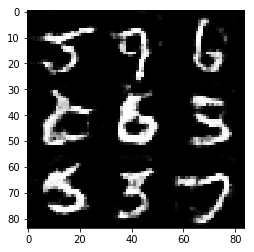

Epoch:1... Batch: 101... Discriminator Loss: 1.2307... Generator Loss: 0.6809
Epoch:1... Batch: 102... Discriminator Loss: 1.0733... Generator Loss: 1.3425
Epoch:1... Batch: 103... Discriminator Loss: 1.0156... Generator Loss: 1.1478
Epoch:1... Batch: 104... Discriminator Loss: 0.9755... Generator Loss: 1.0906
Epoch:1... Batch: 105... Discriminator Loss: 1.0460... Generator Loss: 1.2148
Epoch:1... Batch: 106... Discriminator Loss: 1.0548... Generator Loss: 1.1448
Epoch:1... Batch: 107... Discriminator Loss: 0.9690... Generator Loss: 1.2297
Epoch:1... Batch: 108... Discriminator Loss: 1.1031... Generator Loss: 0.9917
Epoch:1... Batch: 109... Discriminator Loss: 1.0425... Generator Loss: 1.4722
Epoch:1... Batch: 110... Discriminator Loss: 1.0413... Generator Loss: 0.8758
Epoch:1... Batch: 111... Discriminator Loss: 1.0482... Generator Loss: 1.3064
Epoch:1... Batch: 112... Discriminator Loss: 1.0328... Generator Loss: 1.1574
Epoch:1... Batch: 113... Discriminator Loss: 1.1603... Generator

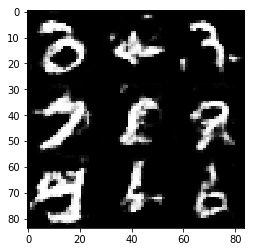

Epoch:1... Batch: 126... Discriminator Loss: 1.1425... Generator Loss: 1.9975
Epoch:1... Batch: 127... Discriminator Loss: 1.1125... Generator Loss: 0.7471
Epoch:1... Batch: 128... Discriminator Loss: 1.0444... Generator Loss: 1.4448
Epoch:1... Batch: 129... Discriminator Loss: 1.0086... Generator Loss: 1.1875
Epoch:1... Batch: 130... Discriminator Loss: 1.0689... Generator Loss: 0.9435
Epoch:1... Batch: 131... Discriminator Loss: 1.0094... Generator Loss: 1.6867
Epoch:1... Batch: 132... Discriminator Loss: 1.0663... Generator Loss: 0.7047
Epoch:1... Batch: 133... Discriminator Loss: 1.1058... Generator Loss: 1.7852
Epoch:1... Batch: 134... Discriminator Loss: 0.9673... Generator Loss: 0.9671
Epoch:1... Batch: 135... Discriminator Loss: 1.0667... Generator Loss: 1.3944
Epoch:1... Batch: 136... Discriminator Loss: 0.9751... Generator Loss: 1.2568
Epoch:1... Batch: 137... Discriminator Loss: 1.0415... Generator Loss: 1.1110
Epoch:1... Batch: 138... Discriminator Loss: 1.0101... Generator

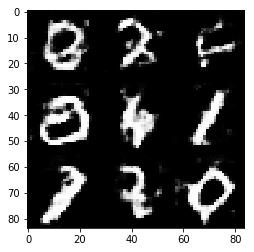

Epoch:1... Batch: 151... Discriminator Loss: 1.2403... Generator Loss: 0.8333
Epoch:1... Batch: 152... Discriminator Loss: 1.0259... Generator Loss: 1.3095
Epoch:1... Batch: 153... Discriminator Loss: 1.1336... Generator Loss: 0.8659
Epoch:1... Batch: 154... Discriminator Loss: 0.9704... Generator Loss: 1.4642
Epoch:1... Batch: 155... Discriminator Loss: 0.9281... Generator Loss: 1.2395
Epoch:1... Batch: 156... Discriminator Loss: 1.0945... Generator Loss: 1.0638
Epoch:1... Batch: 157... Discriminator Loss: 1.0719... Generator Loss: 1.0153
Epoch:1... Batch: 158... Discriminator Loss: 1.0535... Generator Loss: 1.5800
Epoch:1... Batch: 159... Discriminator Loss: 1.1724... Generator Loss: 0.5276
Epoch:1... Batch: 160... Discriminator Loss: 1.1259... Generator Loss: 1.8875
Epoch:1... Batch: 161... Discriminator Loss: 1.0854... Generator Loss: 1.0379
Epoch:1... Batch: 162... Discriminator Loss: 0.9749... Generator Loss: 1.1640
Epoch:1... Batch: 163... Discriminator Loss: 1.0549... Generator

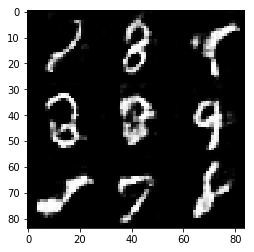

Epoch:1... Batch: 176... Discriminator Loss: 1.2556... Generator Loss: 1.8084
Epoch:1... Batch: 177... Discriminator Loss: 1.0047... Generator Loss: 1.2651
Epoch:1... Batch: 178... Discriminator Loss: 1.0198... Generator Loss: 0.8233
Epoch:1... Batch: 179... Discriminator Loss: 0.9998... Generator Loss: 1.5398
Epoch:1... Batch: 180... Discriminator Loss: 1.0977... Generator Loss: 0.8158
Epoch:1... Batch: 181... Discriminator Loss: 0.9813... Generator Loss: 1.3714
Epoch:1... Batch: 182... Discriminator Loss: 0.9699... Generator Loss: 1.1606
Epoch:1... Batch: 183... Discriminator Loss: 0.9769... Generator Loss: 1.1352
Epoch:1... Batch: 184... Discriminator Loss: 0.9878... Generator Loss: 1.3045
Epoch:1... Batch: 185... Discriminator Loss: 1.0223... Generator Loss: 1.1729
Epoch:1... Batch: 186... Discriminator Loss: 0.9900... Generator Loss: 1.1232
Epoch:1... Batch: 187... Discriminator Loss: 1.0031... Generator Loss: 1.2749
Epoch:1... Batch: 188... Discriminator Loss: 1.0397... Generator

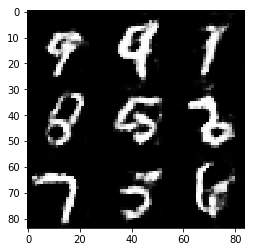

Epoch:1... Batch: 201... Discriminator Loss: 1.0441... Generator Loss: 1.5317
Epoch:1... Batch: 202... Discriminator Loss: 1.2339... Generator Loss: 0.6355
Epoch:1... Batch: 203... Discriminator Loss: 1.0412... Generator Loss: 2.0908
Epoch:1... Batch: 204... Discriminator Loss: 1.0932... Generator Loss: 0.7140
Epoch:1... Batch: 205... Discriminator Loss: 0.9957... Generator Loss: 1.7091
Epoch:1... Batch: 206... Discriminator Loss: 1.1281... Generator Loss: 0.6798
Epoch:1... Batch: 207... Discriminator Loss: 1.1154... Generator Loss: 1.8364
Epoch:1... Batch: 208... Discriminator Loss: 1.0396... Generator Loss: 1.0029
Epoch:1... Batch: 209... Discriminator Loss: 0.9107... Generator Loss: 1.6077
Epoch:1... Batch: 210... Discriminator Loss: 0.9657... Generator Loss: 0.9877
Epoch:1... Batch: 211... Discriminator Loss: 1.1636... Generator Loss: 1.2583
Epoch:1... Batch: 212... Discriminator Loss: 1.0080... Generator Loss: 1.2122
Epoch:1... Batch: 213... Discriminator Loss: 1.1111... Generator

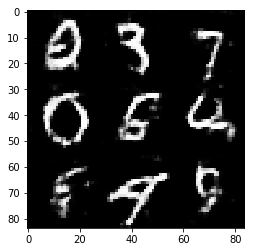

Epoch:1... Batch: 226... Discriminator Loss: 1.0030... Generator Loss: 1.2662
Epoch:1... Batch: 227... Discriminator Loss: 0.8985... Generator Loss: 1.4567
Epoch:1... Batch: 228... Discriminator Loss: 0.9485... Generator Loss: 1.2305
Epoch:1... Batch: 229... Discriminator Loss: 0.9649... Generator Loss: 1.2199
Epoch:1... Batch: 230... Discriminator Loss: 0.9499... Generator Loss: 1.0487
Epoch:1... Batch: 231... Discriminator Loss: 1.0404... Generator Loss: 2.2446
Epoch:1... Batch: 232... Discriminator Loss: 1.1795... Generator Loss: 0.3396
Epoch:1... Batch: 233... Discriminator Loss: 1.2853... Generator Loss: 2.6762
Epoch:1... Batch: 234... Discriminator Loss: 1.3312... Generator Loss: 0.6781
Epoch:1... Batch: 235... Discriminator Loss: 1.1377... Generator Loss: 2.0349
Epoch:1... Batch: 236... Discriminator Loss: 0.9649... Generator Loss: 0.9024
Epoch:1... Batch: 237... Discriminator Loss: 0.9752... Generator Loss: 1.4207
Epoch:1... Batch: 238... Discriminator Loss: 0.9764... Generator

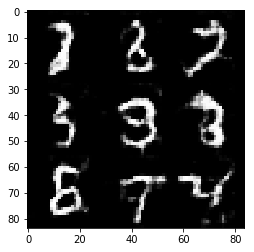

Epoch:1... Batch: 251... Discriminator Loss: 1.0561... Generator Loss: 0.9966
Epoch:1... Batch: 252... Discriminator Loss: 0.8483... Generator Loss: 1.4836
Epoch:1... Batch: 253... Discriminator Loss: 0.9844... Generator Loss: 1.2103
Epoch:1... Batch: 254... Discriminator Loss: 0.9019... Generator Loss: 1.1820
Epoch:1... Batch: 255... Discriminator Loss: 0.9584... Generator Loss: 1.2932
Epoch:1... Batch: 256... Discriminator Loss: 0.9496... Generator Loss: 1.2972
Epoch:1... Batch: 257... Discriminator Loss: 1.1136... Generator Loss: 1.0713
Epoch:1... Batch: 258... Discriminator Loss: 0.9469... Generator Loss: 1.2076
Epoch:1... Batch: 259... Discriminator Loss: 0.9862... Generator Loss: 1.5341
Epoch:1... Batch: 260... Discriminator Loss: 1.0496... Generator Loss: 0.9609
Epoch:1... Batch: 261... Discriminator Loss: 0.9051... Generator Loss: 1.2774
Epoch:1... Batch: 262... Discriminator Loss: 1.0511... Generator Loss: 1.1109
Epoch:1... Batch: 263... Discriminator Loss: 0.8784... Generator

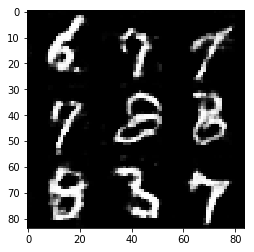

Epoch:1... Batch: 276... Discriminator Loss: 0.9715... Generator Loss: 0.9091
Epoch:1... Batch: 277... Discriminator Loss: 0.9198... Generator Loss: 1.6040
Epoch:1... Batch: 278... Discriminator Loss: 1.0657... Generator Loss: 0.9300
Epoch:1... Batch: 279... Discriminator Loss: 0.9634... Generator Loss: 1.5258
Epoch:1... Batch: 280... Discriminator Loss: 0.9693... Generator Loss: 1.0841
Epoch:1... Batch: 281... Discriminator Loss: 0.9254... Generator Loss: 1.5894
Epoch:1... Batch: 282... Discriminator Loss: 0.9230... Generator Loss: 0.8284
Epoch:1... Batch: 283... Discriminator Loss: 1.0444... Generator Loss: 2.0570
Epoch:1... Batch: 284... Discriminator Loss: 1.1312... Generator Loss: 0.5519
Epoch:1... Batch: 285... Discriminator Loss: 1.2913... Generator Loss: 2.0971
Epoch:1... Batch: 286... Discriminator Loss: 1.2456... Generator Loss: 0.6586
Epoch:1... Batch: 287... Discriminator Loss: 1.0019... Generator Loss: 1.4891
Epoch:1... Batch: 288... Discriminator Loss: 0.9766... Generator

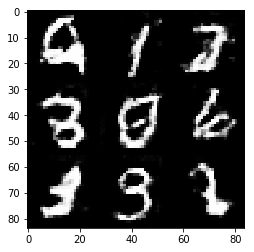

Epoch:1... Batch: 301... Discriminator Loss: 0.8884... Generator Loss: 1.1460
Epoch:1... Batch: 302... Discriminator Loss: 0.9404... Generator Loss: 1.6418
Epoch:1... Batch: 303... Discriminator Loss: 1.0292... Generator Loss: 0.9510
Epoch:1... Batch: 304... Discriminator Loss: 0.9419... Generator Loss: 1.8826
Epoch:1... Batch: 305... Discriminator Loss: 1.0156... Generator Loss: 0.7784
Epoch:1... Batch: 306... Discriminator Loss: 0.8926... Generator Loss: 1.7484
Epoch:1... Batch: 307... Discriminator Loss: 0.8957... Generator Loss: 0.9667
Epoch:1... Batch: 308... Discriminator Loss: 1.0058... Generator Loss: 1.7985
Epoch:1... Batch: 309... Discriminator Loss: 0.9742... Generator Loss: 0.6500
Epoch:1... Batch: 310... Discriminator Loss: 1.2404... Generator Loss: 2.9313
Epoch:1... Batch: 311... Discriminator Loss: 1.3908... Generator Loss: 0.5029
Epoch:1... Batch: 312... Discriminator Loss: 1.2143... Generator Loss: 2.6372
Epoch:1... Batch: 313... Discriminator Loss: 1.3308... Generator

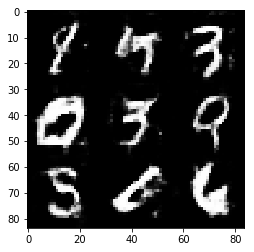

Epoch:1... Batch: 326... Discriminator Loss: 0.9475... Generator Loss: 1.3013
Epoch:1... Batch: 327... Discriminator Loss: 0.8801... Generator Loss: 1.2994
Epoch:1... Batch: 328... Discriminator Loss: 1.0390... Generator Loss: 1.1559
Epoch:1... Batch: 329... Discriminator Loss: 0.9007... Generator Loss: 1.4236
Epoch:1... Batch: 330... Discriminator Loss: 0.9137... Generator Loss: 1.0211
Epoch:1... Batch: 331... Discriminator Loss: 0.9143... Generator Loss: 1.7238
Epoch:1... Batch: 332... Discriminator Loss: 0.9712... Generator Loss: 0.8106
Epoch:1... Batch: 333... Discriminator Loss: 1.1029... Generator Loss: 2.2826
Epoch:1... Batch: 334... Discriminator Loss: 1.2754... Generator Loss: 0.4777
Epoch:1... Batch: 335... Discriminator Loss: 1.1612... Generator Loss: 2.2415
Epoch:1... Batch: 336... Discriminator Loss: 1.1357... Generator Loss: 0.8428
Epoch:1... Batch: 337... Discriminator Loss: 1.0765... Generator Loss: 1.6967
Epoch:1... Batch: 338... Discriminator Loss: 1.0518... Generator

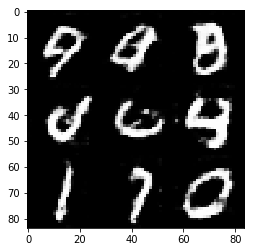

Epoch:1... Batch: 351... Discriminator Loss: 0.9557... Generator Loss: 1.5481
Epoch:1... Batch: 352... Discriminator Loss: 1.0238... Generator Loss: 0.8903
Epoch:1... Batch: 353... Discriminator Loss: 0.9787... Generator Loss: 1.3502
Epoch:1... Batch: 354... Discriminator Loss: 0.9421... Generator Loss: 1.4485
Epoch:1... Batch: 355... Discriminator Loss: 0.8901... Generator Loss: 0.9911
Epoch:1... Batch: 356... Discriminator Loss: 1.0635... Generator Loss: 2.3110
Epoch:1... Batch: 357... Discriminator Loss: 1.3337... Generator Loss: 0.3498
Epoch:1... Batch: 358... Discriminator Loss: 1.3895... Generator Loss: 2.7050
Epoch:1... Batch: 359... Discriminator Loss: 1.1594... Generator Loss: 0.9110
Epoch:1... Batch: 360... Discriminator Loss: 0.9994... Generator Loss: 1.9161
Epoch:1... Batch: 361... Discriminator Loss: 0.9959... Generator Loss: 0.9166
Epoch:1... Batch: 362... Discriminator Loss: 0.9929... Generator Loss: 1.7619
Epoch:1... Batch: 363... Discriminator Loss: 0.9828... Generator

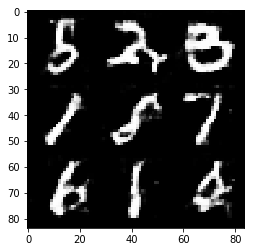

Epoch:1... Batch: 376... Discriminator Loss: 0.8735... Generator Loss: 1.5066
Epoch:1... Batch: 377... Discriminator Loss: 0.8996... Generator Loss: 1.5822
Epoch:1... Batch: 378... Discriminator Loss: 0.9067... Generator Loss: 0.8575
Epoch:1... Batch: 379... Discriminator Loss: 0.9654... Generator Loss: 2.0699
Epoch:1... Batch: 380... Discriminator Loss: 1.1339... Generator Loss: 0.7842
Epoch:1... Batch: 381... Discriminator Loss: 0.9526... Generator Loss: 1.7170
Epoch:1... Batch: 382... Discriminator Loss: 0.9157... Generator Loss: 0.8203
Epoch:1... Batch: 383... Discriminator Loss: 1.0400... Generator Loss: 2.4759
Epoch:1... Batch: 384... Discriminator Loss: 1.1640... Generator Loss: 0.5982
Epoch:1... Batch: 385... Discriminator Loss: 1.0035... Generator Loss: 1.9538
Epoch:1... Batch: 386... Discriminator Loss: 1.0174... Generator Loss: 1.0662
Epoch:1... Batch: 387... Discriminator Loss: 1.0148... Generator Loss: 1.5513
Epoch:1... Batch: 388... Discriminator Loss: 0.9429... Generator

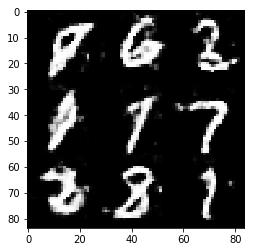

Epoch:1... Batch: 401... Discriminator Loss: 0.9452... Generator Loss: 1.1691
Epoch:1... Batch: 402... Discriminator Loss: 1.0093... Generator Loss: 1.4209
Epoch:1... Batch: 403... Discriminator Loss: 1.0071... Generator Loss: 1.0378
Epoch:1... Batch: 404... Discriminator Loss: 1.0609... Generator Loss: 1.5037
Epoch:1... Batch: 405... Discriminator Loss: 0.8997... Generator Loss: 1.0001
Epoch:1... Batch: 406... Discriminator Loss: 0.8337... Generator Loss: 1.5973
Epoch:1... Batch: 407... Discriminator Loss: 0.9128... Generator Loss: 1.1330
Epoch:1... Batch: 408... Discriminator Loss: 0.8851... Generator Loss: 1.4722
Epoch:1... Batch: 409... Discriminator Loss: 0.8946... Generator Loss: 1.0564
Epoch:1... Batch: 410... Discriminator Loss: 0.8674... Generator Loss: 1.8198
Epoch:1... Batch: 411... Discriminator Loss: 1.0878... Generator Loss: 0.8531
Epoch:1... Batch: 412... Discriminator Loss: 0.9973... Generator Loss: 1.3468
Epoch:1... Batch: 413... Discriminator Loss: 0.8183... Generator

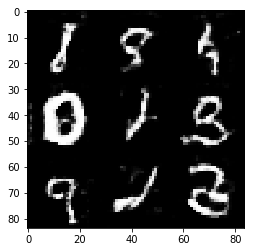

Epoch:1... Batch: 426... Discriminator Loss: 0.9229... Generator Loss: 0.9704
Epoch:1... Batch: 427... Discriminator Loss: 0.9485... Generator Loss: 2.0328
Epoch:1... Batch: 428... Discriminator Loss: 1.1109... Generator Loss: 0.4981
Epoch:1... Batch: 429... Discriminator Loss: 1.2250... Generator Loss: 2.6319
Epoch:1... Batch: 430... Discriminator Loss: 1.3089... Generator Loss: 0.5685
Epoch:1... Batch: 431... Discriminator Loss: 1.0867... Generator Loss: 3.1340
Epoch:1... Batch: 432... Discriminator Loss: 1.7829... Generator Loss: 0.2488
Epoch:1... Batch: 433... Discriminator Loss: 1.6087... Generator Loss: 3.7713
Epoch:1... Batch: 434... Discriminator Loss: 2.1475... Generator Loss: 0.3973
Epoch:1... Batch: 435... Discriminator Loss: 1.8043... Generator Loss: 2.3782
Epoch:1... Batch: 436... Discriminator Loss: 1.0861... Generator Loss: 1.6757
Epoch:1... Batch: 437... Discriminator Loss: 1.1900... Generator Loss: 0.6586
Epoch:1... Batch: 438... Discriminator Loss: 0.8836... Generator

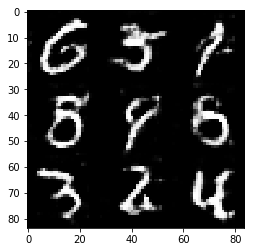

Epoch:1... Batch: 451... Discriminator Loss: 0.8953... Generator Loss: 1.2985
Epoch:1... Batch: 452... Discriminator Loss: 0.8312... Generator Loss: 1.1260
Epoch:1... Batch: 453... Discriminator Loss: 0.9087... Generator Loss: 1.7889
Epoch:1... Batch: 454... Discriminator Loss: 0.9764... Generator Loss: 0.9472
Epoch:1... Batch: 455... Discriminator Loss: 0.8015... Generator Loss: 1.6305
Epoch:1... Batch: 456... Discriminator Loss: 0.8944... Generator Loss: 1.2785
Epoch:1... Batch: 457... Discriminator Loss: 0.7899... Generator Loss: 1.3948
Epoch:1... Batch: 458... Discriminator Loss: 0.8713... Generator Loss: 1.3668
Epoch:1... Batch: 459... Discriminator Loss: 0.8256... Generator Loss: 1.2775
Epoch:1... Batch: 460... Discriminator Loss: 0.8517... Generator Loss: 1.5453
Epoch:1... Batch: 461... Discriminator Loss: 0.7788... Generator Loss: 1.2810
Epoch:1... Batch: 462... Discriminator Loss: 0.8619... Generator Loss: 1.7329
Epoch:1... Batch: 463... Discriminator Loss: 0.9708... Generator

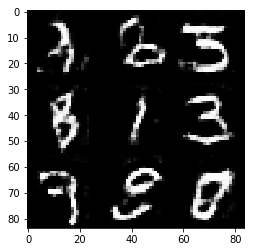

Epoch:1... Batch: 476... Discriminator Loss: 0.9362... Generator Loss: 0.7977
Epoch:1... Batch: 477... Discriminator Loss: 1.0737... Generator Loss: 2.4422
Epoch:1... Batch: 478... Discriminator Loss: 1.2131... Generator Loss: 0.4054
Epoch:1... Batch: 479... Discriminator Loss: 1.2299... Generator Loss: 2.5495
Epoch:1... Batch: 480... Discriminator Loss: 1.0441... Generator Loss: 1.0369
Epoch:1... Batch: 481... Discriminator Loss: 0.8340... Generator Loss: 1.6822
Epoch:1... Batch: 482... Discriminator Loss: 0.8813... Generator Loss: 1.0623
Epoch:1... Batch: 483... Discriminator Loss: 0.9519... Generator Loss: 2.2488
Epoch:1... Batch: 484... Discriminator Loss: 1.1295... Generator Loss: 0.5261
Epoch:1... Batch: 485... Discriminator Loss: 1.1388... Generator Loss: 2.1013
Epoch:1... Batch: 486... Discriminator Loss: 0.8723... Generator Loss: 1.3354
Epoch:1... Batch: 487... Discriminator Loss: 0.8294... Generator Loss: 0.9823
Epoch:1... Batch: 488... Discriminator Loss: 1.0455... Generator

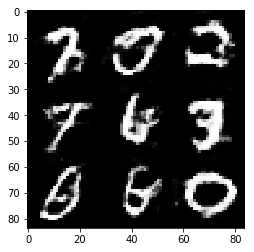

Epoch:1... Batch: 501... Discriminator Loss: 0.9257... Generator Loss: 1.7533
Epoch:1... Batch: 502... Discriminator Loss: 0.8489... Generator Loss: 0.9212
Epoch:1... Batch: 503... Discriminator Loss: 1.0468... Generator Loss: 2.2854
Epoch:1... Batch: 504... Discriminator Loss: 1.0229... Generator Loss: 0.7782
Epoch:1... Batch: 505... Discriminator Loss: 0.9671... Generator Loss: 2.2745
Epoch:1... Batch: 506... Discriminator Loss: 1.0893... Generator Loss: 0.6505
Epoch:1... Batch: 507... Discriminator Loss: 0.9346... Generator Loss: 2.1835


KeyboardInterrupt: 

In [117]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

#tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:0... Batch: 1... Discriminator Loss: 7.4015... Generator Loss: 0.0422
Epoch:0... Batch: 2... Discriminator Loss: 5.2117... Generator Loss: 0.2562
Epoch:0... Batch: 3... Discriminator Loss: 5.1222... Generator Loss: 0.2295
Epoch:0... Batch: 4... Discriminator Loss: 5.3601... Generator Loss: 0.2310
Epoch:0... Batch: 5... Discriminator Loss: 5.5281... Generator Loss: 0.2557
Epoch:0... Batch: 6... Discriminator Loss: 5.4997... Generator Loss: 0.3573
Epoch:0... Batch: 7... Discriminator Loss: 5.3572... Generator Loss: 0.4334
Epoch:0... Batch: 8... Discriminator Loss: 4.6955... Generator Loss: 0.6117
Epoch:0... Batch: 9... Discriminator Loss: 4.1355... Generator Loss: 0.8811
Epoch:0... Batch: 10... Discriminator Loss: 4.7249... Generator Loss: 0.7668
Epoch:0... Batch: 11... Discriminator Loss: 3.7756... Generator Loss: 1.1337
Epoch:0... Batch: 12... Discriminator Loss: 4.2779... Generator Loss: 0.9822
Epoch:0... Batch: 13... Discriminator Loss: 3.1717... Generator Loss: 1.6979
Epoch:0.

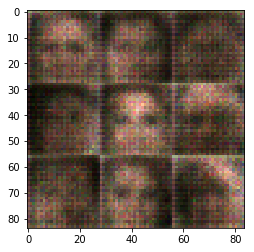

Epoch:0... Batch: 101... Discriminator Loss: 1.6392... Generator Loss: 0.7757
Epoch:0... Batch: 102... Discriminator Loss: 1.6025... Generator Loss: 0.7960
Epoch:0... Batch: 103... Discriminator Loss: 1.7250... Generator Loss: 0.6355
Epoch:0... Batch: 104... Discriminator Loss: 1.6791... Generator Loss: 0.7026
Epoch:0... Batch: 105... Discriminator Loss: 1.6735... Generator Loss: 0.7122
Epoch:0... Batch: 106... Discriminator Loss: 1.7626... Generator Loss: 0.6482
Epoch:0... Batch: 107... Discriminator Loss: 1.7650... Generator Loss: 0.6619
Epoch:0... Batch: 108... Discriminator Loss: 1.7177... Generator Loss: 0.6797
Epoch:0... Batch: 109... Discriminator Loss: 1.6833... Generator Loss: 0.7840
Epoch:0... Batch: 110... Discriminator Loss: 1.6330... Generator Loss: 0.6901
Epoch:0... Batch: 111... Discriminator Loss: 1.6431... Generator Loss: 0.7365
Epoch:0... Batch: 112... Discriminator Loss: 1.7464... Generator Loss: 0.6922
Epoch:0... Batch: 113... Discriminator Loss: 1.7689... Generator

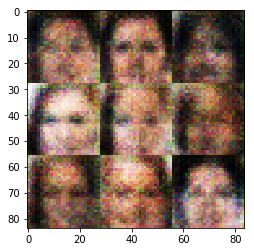

Epoch:0... Batch: 201... Discriminator Loss: 1.5746... Generator Loss: 0.7941
Epoch:0... Batch: 202... Discriminator Loss: 1.6029... Generator Loss: 0.6953
Epoch:0... Batch: 203... Discriminator Loss: 1.5677... Generator Loss: 0.6661
Epoch:0... Batch: 204... Discriminator Loss: 1.5742... Generator Loss: 0.6618
Epoch:0... Batch: 205... Discriminator Loss: 1.5564... Generator Loss: 0.7762
Epoch:0... Batch: 206... Discriminator Loss: 1.4954... Generator Loss: 0.7450
Epoch:0... Batch: 207... Discriminator Loss: 1.4300... Generator Loss: 0.7340
Epoch:0... Batch: 208... Discriminator Loss: 1.4698... Generator Loss: 0.7175
Epoch:0... Batch: 209... Discriminator Loss: 1.4755... Generator Loss: 0.7996
Epoch:0... Batch: 210... Discriminator Loss: 1.4849... Generator Loss: 0.8270
Epoch:0... Batch: 211... Discriminator Loss: 1.5663... Generator Loss: 0.7808
Epoch:0... Batch: 212... Discriminator Loss: 1.5272... Generator Loss: 0.6863
Epoch:0... Batch: 213... Discriminator Loss: 1.4560... Generator

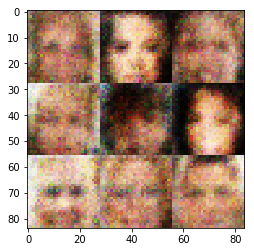

Epoch:0... Batch: 301... Discriminator Loss: 1.4922... Generator Loss: 0.6894
Epoch:0... Batch: 302... Discriminator Loss: 1.4737... Generator Loss: 0.7142
Epoch:0... Batch: 303... Discriminator Loss: 1.5535... Generator Loss: 0.6649
Epoch:0... Batch: 304... Discriminator Loss: 1.5675... Generator Loss: 0.7126
Epoch:0... Batch: 305... Discriminator Loss: 1.4267... Generator Loss: 0.7794
Epoch:0... Batch: 306... Discriminator Loss: 1.4705... Generator Loss: 0.6866
Epoch:0... Batch: 307... Discriminator Loss: 1.4955... Generator Loss: 0.6833
Epoch:0... Batch: 308... Discriminator Loss: 1.4808... Generator Loss: 0.7591
Epoch:0... Batch: 309... Discriminator Loss: 1.5017... Generator Loss: 0.7152
Epoch:0... Batch: 310... Discriminator Loss: 1.4612... Generator Loss: 0.7031
Epoch:0... Batch: 311... Discriminator Loss: 1.5723... Generator Loss: 0.7770
Epoch:0... Batch: 312... Discriminator Loss: 1.5219... Generator Loss: 0.7157
Epoch:0... Batch: 313... Discriminator Loss: 1.5006... Generator

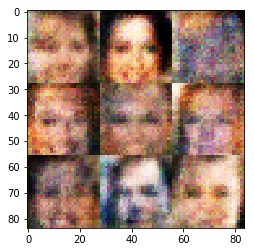

Epoch:0... Batch: 401... Discriminator Loss: 1.4672... Generator Loss: 0.7391
Epoch:0... Batch: 402... Discriminator Loss: 1.5294... Generator Loss: 0.7470
Epoch:0... Batch: 403... Discriminator Loss: 1.4637... Generator Loss: 0.7997
Epoch:0... Batch: 404... Discriminator Loss: 1.4233... Generator Loss: 0.7320
Epoch:0... Batch: 405... Discriminator Loss: 1.4125... Generator Loss: 0.6835
Epoch:0... Batch: 406... Discriminator Loss: 1.4241... Generator Loss: 0.7140
Epoch:0... Batch: 407... Discriminator Loss: 1.4496... Generator Loss: 0.7060
Epoch:0... Batch: 408... Discriminator Loss: 1.4441... Generator Loss: 0.7355
Epoch:0... Batch: 409... Discriminator Loss: 1.4621... Generator Loss: 0.7217
Epoch:0... Batch: 410... Discriminator Loss: 1.4051... Generator Loss: 0.6927
Epoch:0... Batch: 411... Discriminator Loss: 1.4662... Generator Loss: 0.7063
Epoch:0... Batch: 412... Discriminator Loss: 1.4484... Generator Loss: 0.7213
Epoch:0... Batch: 413... Discriminator Loss: 1.4300... Generator

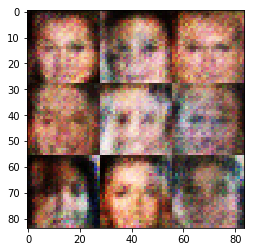

Epoch:0... Batch: 501... Discriminator Loss: 1.4552... Generator Loss: 0.7232
Epoch:0... Batch: 502... Discriminator Loss: 1.4588... Generator Loss: 0.6774
Epoch:0... Batch: 503... Discriminator Loss: 1.4331... Generator Loss: 0.7542
Epoch:0... Batch: 504... Discriminator Loss: 1.5190... Generator Loss: 0.7248
Epoch:0... Batch: 505... Discriminator Loss: 1.4455... Generator Loss: 0.6884
Epoch:0... Batch: 506... Discriminator Loss: 1.4549... Generator Loss: 0.6600
Epoch:0... Batch: 507... Discriminator Loss: 1.4888... Generator Loss: 0.7341
Epoch:0... Batch: 508... Discriminator Loss: 1.4250... Generator Loss: 0.8228
Epoch:0... Batch: 509... Discriminator Loss: 1.4235... Generator Loss: 0.7437
Epoch:0... Batch: 510... Discriminator Loss: 1.4602... Generator Loss: 0.7446
Epoch:0... Batch: 511... Discriminator Loss: 1.4637... Generator Loss: 0.6760
Epoch:0... Batch: 512... Discriminator Loss: 1.4549... Generator Loss: 0.7343
Epoch:0... Batch: 513... Discriminator Loss: 1.4135... Generator

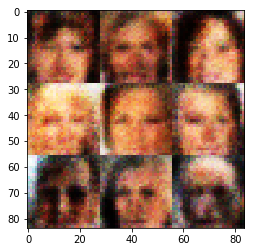

Epoch:0... Batch: 601... Discriminator Loss: 1.4707... Generator Loss: 0.7077
Epoch:0... Batch: 602... Discriminator Loss: 1.4682... Generator Loss: 0.6795
Epoch:0... Batch: 603... Discriminator Loss: 1.4507... Generator Loss: 0.6871
Epoch:0... Batch: 604... Discriminator Loss: 1.4579... Generator Loss: 0.7636
Epoch:0... Batch: 605... Discriminator Loss: 1.4498... Generator Loss: 0.7614
Epoch:0... Batch: 606... Discriminator Loss: 1.4733... Generator Loss: 0.7283
Epoch:0... Batch: 607... Discriminator Loss: 1.4580... Generator Loss: 0.6797
Epoch:0... Batch: 608... Discriminator Loss: 1.4631... Generator Loss: 0.6765
Epoch:0... Batch: 609... Discriminator Loss: 1.4587... Generator Loss: 0.7202
Epoch:0... Batch: 610... Discriminator Loss: 1.4081... Generator Loss: 0.7473
Epoch:0... Batch: 611... Discriminator Loss: 1.4767... Generator Loss: 0.6984
Epoch:0... Batch: 612... Discriminator Loss: 1.4548... Generator Loss: 0.7467
Epoch:0... Batch: 613... Discriminator Loss: 1.4510... Generator

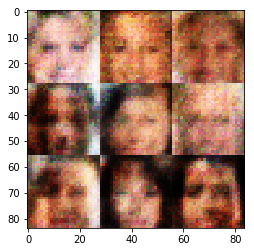

Epoch:0... Batch: 701... Discriminator Loss: 1.4553... Generator Loss: 0.6970
Epoch:0... Batch: 702... Discriminator Loss: 1.4236... Generator Loss: 0.6934
Epoch:0... Batch: 703... Discriminator Loss: 1.4085... Generator Loss: 0.6864
Epoch:0... Batch: 704... Discriminator Loss: 1.4317... Generator Loss: 0.7393
Epoch:0... Batch: 705... Discriminator Loss: 1.3915... Generator Loss: 0.7444
Epoch:0... Batch: 706... Discriminator Loss: 1.4156... Generator Loss: 0.6856
Epoch:0... Batch: 707... Discriminator Loss: 1.4131... Generator Loss: 0.7471
Epoch:0... Batch: 708... Discriminator Loss: 1.4466... Generator Loss: 0.7163
Epoch:0... Batch: 709... Discriminator Loss: 1.4393... Generator Loss: 0.6905
Epoch:0... Batch: 710... Discriminator Loss: 1.4119... Generator Loss: 0.7001
Epoch:0... Batch: 711... Discriminator Loss: 1.4124... Generator Loss: 0.7013
Epoch:0... Batch: 712... Discriminator Loss: 1.4455... Generator Loss: 0.7348
Epoch:0... Batch: 713... Discriminator Loss: 1.4543... Generator

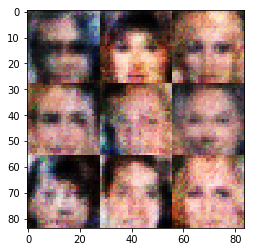

Epoch:0... Batch: 801... Discriminator Loss: 1.4403... Generator Loss: 0.7384
Epoch:0... Batch: 802... Discriminator Loss: 1.4046... Generator Loss: 0.7837
Epoch:0... Batch: 803... Discriminator Loss: 1.4422... Generator Loss: 0.7403
Epoch:0... Batch: 804... Discriminator Loss: 1.4253... Generator Loss: 0.7239
Epoch:0... Batch: 805... Discriminator Loss: 1.4507... Generator Loss: 0.7031
Epoch:0... Batch: 806... Discriminator Loss: 1.4819... Generator Loss: 0.7230
Epoch:0... Batch: 807... Discriminator Loss: 1.4548... Generator Loss: 0.7244
Epoch:0... Batch: 808... Discriminator Loss: 1.4293... Generator Loss: 0.6815
Epoch:0... Batch: 809... Discriminator Loss: 1.4111... Generator Loss: 0.7374
Epoch:0... Batch: 810... Discriminator Loss: 1.4881... Generator Loss: 0.7377
Epoch:0... Batch: 811... Discriminator Loss: 1.4787... Generator Loss: 0.7367
Epoch:0... Batch: 812... Discriminator Loss: 1.4734... Generator Loss: 0.7709
Epoch:0... Batch: 813... Discriminator Loss: 1.5250... Generator

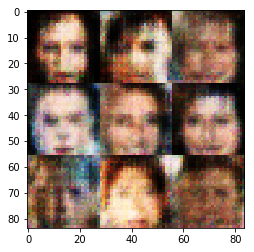

Epoch:0... Batch: 901... Discriminator Loss: 1.4474... Generator Loss: 0.7342
Epoch:0... Batch: 902... Discriminator Loss: 1.4674... Generator Loss: 0.7124
Epoch:0... Batch: 903... Discriminator Loss: 1.4824... Generator Loss: 0.7371
Epoch:0... Batch: 904... Discriminator Loss: 1.4640... Generator Loss: 0.7241
Epoch:0... Batch: 905... Discriminator Loss: 1.5147... Generator Loss: 0.7405
Epoch:0... Batch: 906... Discriminator Loss: 1.4650... Generator Loss: 0.7553
Epoch:0... Batch: 907... Discriminator Loss: 1.4617... Generator Loss: 0.7340
Epoch:0... Batch: 908... Discriminator Loss: 1.4280... Generator Loss: 0.7230
Epoch:0... Batch: 909... Discriminator Loss: 1.4221... Generator Loss: 0.6938
Epoch:0... Batch: 910... Discriminator Loss: 1.4588... Generator Loss: 0.6853
Epoch:0... Batch: 911... Discriminator Loss: 1.4635... Generator Loss: 0.6852
Epoch:0... Batch: 912... Discriminator Loss: 1.5027... Generator Loss: 0.6641
Epoch:0... Batch: 913... Discriminator Loss: 1.4123... Generator

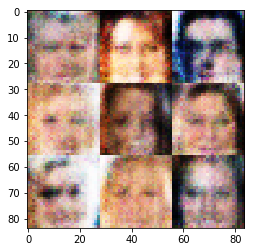

Epoch:0... Batch: 1001... Discriminator Loss: 1.4203... Generator Loss: 0.7121
Epoch:0... Batch: 1002... Discriminator Loss: 1.3841... Generator Loss: 0.7564
Epoch:0... Batch: 1003... Discriminator Loss: 1.4020... Generator Loss: 0.7018
Epoch:0... Batch: 1004... Discriminator Loss: 1.4397... Generator Loss: 0.6759
Epoch:0... Batch: 1005... Discriminator Loss: 1.4441... Generator Loss: 0.6956
Epoch:0... Batch: 1006... Discriminator Loss: 1.4154... Generator Loss: 0.7434
Epoch:0... Batch: 1007... Discriminator Loss: 1.4363... Generator Loss: 0.7150
Epoch:0... Batch: 1008... Discriminator Loss: 1.4302... Generator Loss: 0.6886
Epoch:0... Batch: 1009... Discriminator Loss: 1.4586... Generator Loss: 0.7085
Epoch:0... Batch: 1010... Discriminator Loss: 1.4444... Generator Loss: 0.6958
Epoch:0... Batch: 1011... Discriminator Loss: 1.4155... Generator Loss: 0.6956
Epoch:0... Batch: 1012... Discriminator Loss: 1.3982... Generator Loss: 0.7468
Epoch:0... Batch: 1013... Discriminator Loss: 1.4234

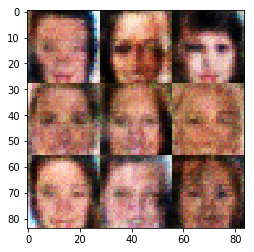

Epoch:0... Batch: 1101... Discriminator Loss: 1.4540... Generator Loss: 0.7009
Epoch:0... Batch: 1102... Discriminator Loss: 1.3918... Generator Loss: 0.6941
Epoch:0... Batch: 1103... Discriminator Loss: 1.4165... Generator Loss: 0.6948
Epoch:0... Batch: 1104... Discriminator Loss: 1.4384... Generator Loss: 0.7188
Epoch:0... Batch: 1105... Discriminator Loss: 1.4616... Generator Loss: 0.7593
Epoch:0... Batch: 1106... Discriminator Loss: 1.4161... Generator Loss: 0.7325
Epoch:0... Batch: 1107... Discriminator Loss: 1.4248... Generator Loss: 0.7190
Epoch:0... Batch: 1108... Discriminator Loss: 1.4447... Generator Loss: 0.7124
Epoch:0... Batch: 1109... Discriminator Loss: 1.4573... Generator Loss: 0.7282
Epoch:0... Batch: 1110... Discriminator Loss: 1.3771... Generator Loss: 0.7550
Epoch:0... Batch: 1111... Discriminator Loss: 1.3669... Generator Loss: 0.7289
Epoch:0... Batch: 1112... Discriminator Loss: 1.3975... Generator Loss: 0.6907
Epoch:0... Batch: 1113... Discriminator Loss: 1.4138

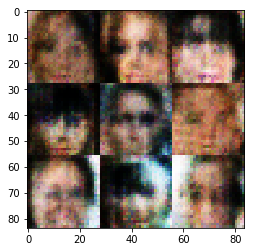

Epoch:0... Batch: 1201... Discriminator Loss: 1.4074... Generator Loss: 0.7391
Epoch:0... Batch: 1202... Discriminator Loss: 1.4462... Generator Loss: 0.7029
Epoch:0... Batch: 1203... Discriminator Loss: 1.4266... Generator Loss: 0.7288
Epoch:0... Batch: 1204... Discriminator Loss: 1.4419... Generator Loss: 0.6725
Epoch:0... Batch: 1205... Discriminator Loss: 1.4111... Generator Loss: 0.7043
Epoch:0... Batch: 1206... Discriminator Loss: 1.4283... Generator Loss: 0.7004
Epoch:0... Batch: 1207... Discriminator Loss: 1.4222... Generator Loss: 0.7693
Epoch:0... Batch: 1208... Discriminator Loss: 1.3923... Generator Loss: 0.7297
Epoch:0... Batch: 1209... Discriminator Loss: 1.4358... Generator Loss: 0.6990
Epoch:0... Batch: 1210... Discriminator Loss: 1.4782... Generator Loss: 0.6780
Epoch:0... Batch: 1211... Discriminator Loss: 1.4710... Generator Loss: 0.7011
Epoch:0... Batch: 1212... Discriminator Loss: 1.4463... Generator Loss: 0.7606
Epoch:0... Batch: 1213... Discriminator Loss: 1.4075

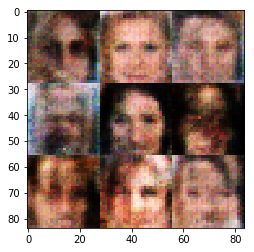

Epoch:0... Batch: 1301... Discriminator Loss: 1.4408... Generator Loss: 0.7337
Epoch:0... Batch: 1302... Discriminator Loss: 1.4029... Generator Loss: 0.7996
Epoch:0... Batch: 1303... Discriminator Loss: 1.4210... Generator Loss: 0.6799
Epoch:0... Batch: 1304... Discriminator Loss: 1.4273... Generator Loss: 0.6405
Epoch:0... Batch: 1305... Discriminator Loss: 1.3911... Generator Loss: 0.7548
Epoch:0... Batch: 1306... Discriminator Loss: 1.4470... Generator Loss: 0.7448
Epoch:0... Batch: 1307... Discriminator Loss: 1.4628... Generator Loss: 0.6803
Epoch:0... Batch: 1308... Discriminator Loss: 1.4463... Generator Loss: 0.6521
Epoch:0... Batch: 1309... Discriminator Loss: 1.4133... Generator Loss: 0.7543
Epoch:0... Batch: 1310... Discriminator Loss: 1.3980... Generator Loss: 0.7841
Epoch:0... Batch: 1311... Discriminator Loss: 1.4148... Generator Loss: 0.6935
Epoch:0... Batch: 1312... Discriminator Loss: 1.4448... Generator Loss: 0.6615
Epoch:0... Batch: 1313... Discriminator Loss: 1.4008

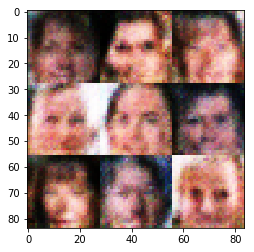

Epoch:0... Batch: 1401... Discriminator Loss: 1.4329... Generator Loss: 0.6741
Epoch:0... Batch: 1402... Discriminator Loss: 1.4150... Generator Loss: 0.6455
Epoch:0... Batch: 1403... Discriminator Loss: 1.4273... Generator Loss: 0.7060
Epoch:0... Batch: 1404... Discriminator Loss: 1.3879... Generator Loss: 0.7296
Epoch:0... Batch: 1405... Discriminator Loss: 1.4418... Generator Loss: 0.7186
Epoch:0... Batch: 1406... Discriminator Loss: 1.4635... Generator Loss: 0.6955
Epoch:0... Batch: 1407... Discriminator Loss: 1.4636... Generator Loss: 0.7790
Epoch:0... Batch: 1408... Discriminator Loss: 1.4217... Generator Loss: 0.7464
Epoch:0... Batch: 1409... Discriminator Loss: 1.3892... Generator Loss: 0.7231
Epoch:0... Batch: 1410... Discriminator Loss: 1.3926... Generator Loss: 0.7101
Epoch:0... Batch: 1411... Discriminator Loss: 1.3934... Generator Loss: 0.7322
Epoch:0... Batch: 1412... Discriminator Loss: 1.4345... Generator Loss: 0.8122
Epoch:0... Batch: 1413... Discriminator Loss: 1.4369

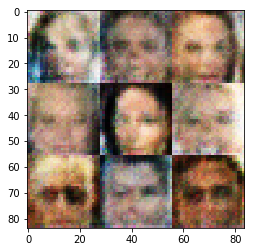

Epoch:0... Batch: 1501... Discriminator Loss: 1.4046... Generator Loss: 0.7334
Epoch:0... Batch: 1502... Discriminator Loss: 1.4377... Generator Loss: 0.6762
Epoch:0... Batch: 1503... Discriminator Loss: 1.4626... Generator Loss: 0.6452
Epoch:0... Batch: 1504... Discriminator Loss: 1.4993... Generator Loss: 0.7144
Epoch:0... Batch: 1505... Discriminator Loss: 1.4608... Generator Loss: 0.7293
Epoch:0... Batch: 1506... Discriminator Loss: 1.4272... Generator Loss: 0.7255
Epoch:0... Batch: 1507... Discriminator Loss: 1.4544... Generator Loss: 0.6671
Epoch:0... Batch: 1508... Discriminator Loss: 1.3849... Generator Loss: 0.7031
Epoch:0... Batch: 1509... Discriminator Loss: 1.3880... Generator Loss: 0.7553
Epoch:0... Batch: 1510... Discriminator Loss: 1.3775... Generator Loss: 0.7630
Epoch:0... Batch: 1511... Discriminator Loss: 1.3953... Generator Loss: 0.7700
Epoch:0... Batch: 1512... Discriminator Loss: 1.4362... Generator Loss: 0.7307
Epoch:0... Batch: 1513... Discriminator Loss: 1.4717

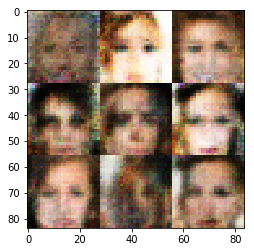

Epoch:0... Batch: 1601... Discriminator Loss: 1.4426... Generator Loss: 0.7317
Epoch:0... Batch: 1602... Discriminator Loss: 1.4460... Generator Loss: 0.7363
Epoch:0... Batch: 1603... Discriminator Loss: 1.4370... Generator Loss: 0.7280
Epoch:0... Batch: 1604... Discriminator Loss: 1.3877... Generator Loss: 0.7257
Epoch:0... Batch: 1605... Discriminator Loss: 1.3960... Generator Loss: 0.7066
Epoch:0... Batch: 1606... Discriminator Loss: 1.4008... Generator Loss: 0.6840
Epoch:0... Batch: 1607... Discriminator Loss: 1.4576... Generator Loss: 0.6906
Epoch:0... Batch: 1608... Discriminator Loss: 1.4375... Generator Loss: 0.7352
Epoch:0... Batch: 1609... Discriminator Loss: 1.4274... Generator Loss: 0.7109
Epoch:0... Batch: 1610... Discriminator Loss: 1.4278... Generator Loss: 0.7208
Epoch:0... Batch: 1611... Discriminator Loss: 1.3978... Generator Loss: 0.7566
Epoch:0... Batch: 1612... Discriminator Loss: 1.4072... Generator Loss: 0.6807
Epoch:0... Batch: 1613... Discriminator Loss: 1.4200

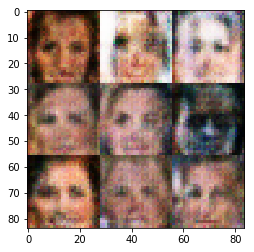

Epoch:0... Batch: 1701... Discriminator Loss: 1.3729... Generator Loss: 0.7529
Epoch:0... Batch: 1702... Discriminator Loss: 1.4078... Generator Loss: 0.7158
Epoch:0... Batch: 1703... Discriminator Loss: 1.4527... Generator Loss: 0.7175
Epoch:0... Batch: 1704... Discriminator Loss: 1.4035... Generator Loss: 0.7233
Epoch:0... Batch: 1705... Discriminator Loss: 1.4592... Generator Loss: 0.6946
Epoch:0... Batch: 1706... Discriminator Loss: 1.3961... Generator Loss: 0.7063
Epoch:0... Batch: 1707... Discriminator Loss: 1.4253... Generator Loss: 0.7112
Epoch:0... Batch: 1708... Discriminator Loss: 1.3753... Generator Loss: 0.7532
Epoch:0... Batch: 1709... Discriminator Loss: 1.3643... Generator Loss: 0.7319
Epoch:0... Batch: 1710... Discriminator Loss: 1.4133... Generator Loss: 0.6829
Epoch:0... Batch: 1711... Discriminator Loss: 1.3922... Generator Loss: 0.7274
Epoch:0... Batch: 1712... Discriminator Loss: 1.4578... Generator Loss: 0.7804
Epoch:0... Batch: 1713... Discriminator Loss: 1.4367

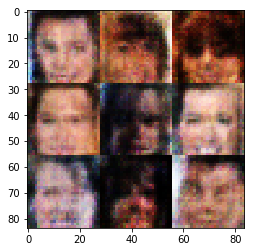

Epoch:0... Batch: 1801... Discriminator Loss: 1.4132... Generator Loss: 0.6990
Epoch:0... Batch: 1802... Discriminator Loss: 1.4405... Generator Loss: 0.7302
Epoch:0... Batch: 1803... Discriminator Loss: 1.4087... Generator Loss: 0.7773
Epoch:0... Batch: 1804... Discriminator Loss: 1.4019... Generator Loss: 0.7446
Epoch:0... Batch: 1805... Discriminator Loss: 1.4051... Generator Loss: 0.6661
Epoch:0... Batch: 1806... Discriminator Loss: 1.4041... Generator Loss: 0.6556
Epoch:0... Batch: 1807... Discriminator Loss: 1.4130... Generator Loss: 0.6949
Epoch:0... Batch: 1808... Discriminator Loss: 1.4061... Generator Loss: 0.7620
Epoch:0... Batch: 1809... Discriminator Loss: 1.4253... Generator Loss: 0.7266
Epoch:0... Batch: 1810... Discriminator Loss: 1.3978... Generator Loss: 0.6941
Epoch:0... Batch: 1811... Discriminator Loss: 1.4042... Generator Loss: 0.7501
Epoch:0... Batch: 1812... Discriminator Loss: 1.4223... Generator Loss: 0.6708
Epoch:0... Batch: 1813... Discriminator Loss: 1.4243

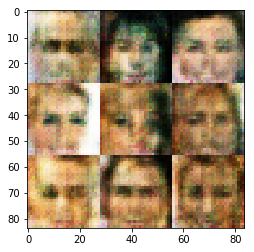

Epoch:0... Batch: 1901... Discriminator Loss: 1.4732... Generator Loss: 0.7378
Epoch:0... Batch: 1902... Discriminator Loss: 1.4391... Generator Loss: 0.7368
Epoch:0... Batch: 1903... Discriminator Loss: 1.4301... Generator Loss: 0.7029
Epoch:0... Batch: 1904... Discriminator Loss: 1.3915... Generator Loss: 0.7445
Epoch:0... Batch: 1905... Discriminator Loss: 1.4499... Generator Loss: 0.7687
Epoch:0... Batch: 1906... Discriminator Loss: 1.4336... Generator Loss: 0.7319
Epoch:0... Batch: 1907... Discriminator Loss: 1.4323... Generator Loss: 0.6865
Epoch:0... Batch: 1908... Discriminator Loss: 1.4442... Generator Loss: 0.6848
Epoch:0... Batch: 1909... Discriminator Loss: 1.4610... Generator Loss: 0.7451
Epoch:0... Batch: 1910... Discriminator Loss: 1.4613... Generator Loss: 0.7525
Epoch:0... Batch: 1911... Discriminator Loss: 1.4515... Generator Loss: 0.6865
Epoch:0... Batch: 1912... Discriminator Loss: 1.4490... Generator Loss: 0.6222
Epoch:0... Batch: 1913... Discriminator Loss: 1.4495

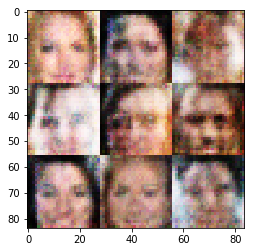

Epoch:0... Batch: 2001... Discriminator Loss: 1.4067... Generator Loss: 0.6723
Epoch:0... Batch: 2002... Discriminator Loss: 1.4364... Generator Loss: 0.7184
Epoch:0... Batch: 2003... Discriminator Loss: 1.3995... Generator Loss: 0.7516
Epoch:0... Batch: 2004... Discriminator Loss: 1.4227... Generator Loss: 0.7484
Epoch:0... Batch: 2005... Discriminator Loss: 1.4166... Generator Loss: 0.7085
Epoch:0... Batch: 2006... Discriminator Loss: 1.3987... Generator Loss: 0.7209
Epoch:0... Batch: 2007... Discriminator Loss: 1.3821... Generator Loss: 0.7580
Epoch:0... Batch: 2008... Discriminator Loss: 1.4208... Generator Loss: 0.7222
Epoch:0... Batch: 2009... Discriminator Loss: 1.4841... Generator Loss: 0.6536
Epoch:0... Batch: 2010... Discriminator Loss: 1.4698... Generator Loss: 0.6904
Epoch:0... Batch: 2011... Discriminator Loss: 1.4394... Generator Loss: 0.6716
Epoch:0... Batch: 2012... Discriminator Loss: 1.4062... Generator Loss: 0.7120
Epoch:0... Batch: 2013... Discriminator Loss: 1.3923

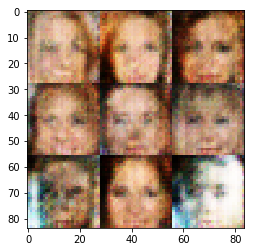

Epoch:0... Batch: 2101... Discriminator Loss: 1.4188... Generator Loss: 0.6947
Epoch:0... Batch: 2102... Discriminator Loss: 1.4177... Generator Loss: 0.7281
Epoch:0... Batch: 2103... Discriminator Loss: 1.3934... Generator Loss: 0.7171
Epoch:0... Batch: 2104... Discriminator Loss: 1.4173... Generator Loss: 0.6769
Epoch:0... Batch: 2105... Discriminator Loss: 1.4028... Generator Loss: 0.6871
Epoch:0... Batch: 2106... Discriminator Loss: 1.3788... Generator Loss: 0.7572
Epoch:0... Batch: 2107... Discriminator Loss: 1.3666... Generator Loss: 0.7806
Epoch:0... Batch: 2108... Discriminator Loss: 1.4102... Generator Loss: 0.7224
Epoch:0... Batch: 2109... Discriminator Loss: 1.4417... Generator Loss: 0.7296
Epoch:0... Batch: 2110... Discriminator Loss: 1.4548... Generator Loss: 0.7748
Epoch:0... Batch: 2111... Discriminator Loss: 1.4552... Generator Loss: 0.7360
Epoch:0... Batch: 2112... Discriminator Loss: 1.4354... Generator Loss: 0.6515
Epoch:0... Batch: 2113... Discriminator Loss: 1.4947

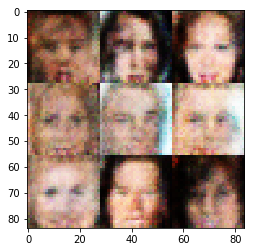

Epoch:0... Batch: 2201... Discriminator Loss: 1.4386... Generator Loss: 0.7022
Epoch:0... Batch: 2202... Discriminator Loss: 1.4121... Generator Loss: 0.7083
Epoch:0... Batch: 2203... Discriminator Loss: 1.4434... Generator Loss: 0.7015
Epoch:0... Batch: 2204... Discriminator Loss: 1.4300... Generator Loss: 0.6808
Epoch:0... Batch: 2205... Discriminator Loss: 1.4265... Generator Loss: 0.6923
Epoch:0... Batch: 2206... Discriminator Loss: 1.4374... Generator Loss: 0.7003
Epoch:0... Batch: 2207... Discriminator Loss: 1.4185... Generator Loss: 0.7224
Epoch:0... Batch: 2208... Discriminator Loss: 1.4236... Generator Loss: 0.6994
Epoch:0... Batch: 2209... Discriminator Loss: 1.3922... Generator Loss: 0.7106
Epoch:0... Batch: 2210... Discriminator Loss: 1.3841... Generator Loss: 0.7287
Epoch:0... Batch: 2211... Discriminator Loss: 1.3537... Generator Loss: 0.7394
Epoch:0... Batch: 2212... Discriminator Loss: 1.4107... Generator Loss: 0.6996
Epoch:0... Batch: 2213... Discriminator Loss: 1.4249

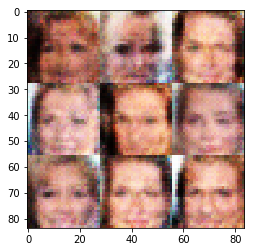

Epoch:0... Batch: 2301... Discriminator Loss: 1.4181... Generator Loss: 0.7204
Epoch:0... Batch: 2302... Discriminator Loss: 1.4155... Generator Loss: 0.6637
Epoch:0... Batch: 2303... Discriminator Loss: 1.4171... Generator Loss: 0.6751
Epoch:0... Batch: 2304... Discriminator Loss: 1.4209... Generator Loss: 0.6968
Epoch:0... Batch: 2305... Discriminator Loss: 1.3856... Generator Loss: 0.7435
Epoch:0... Batch: 2306... Discriminator Loss: 1.4031... Generator Loss: 0.7255
Epoch:0... Batch: 2307... Discriminator Loss: 1.4695... Generator Loss: 0.7129
Epoch:0... Batch: 2308... Discriminator Loss: 1.4046... Generator Loss: 0.7318
Epoch:0... Batch: 2309... Discriminator Loss: 1.3934... Generator Loss: 0.7146
Epoch:0... Batch: 2310... Discriminator Loss: 1.3905... Generator Loss: 0.7135
Epoch:0... Batch: 2311... Discriminator Loss: 1.4088... Generator Loss: 0.6939
Epoch:0... Batch: 2312... Discriminator Loss: 1.3871... Generator Loss: 0.7186
Epoch:0... Batch: 2313... Discriminator Loss: 1.3975

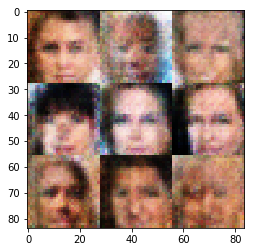

Epoch:0... Batch: 2401... Discriminator Loss: 1.3933... Generator Loss: 0.7337
Epoch:0... Batch: 2402... Discriminator Loss: 1.3790... Generator Loss: 0.7327
Epoch:0... Batch: 2403... Discriminator Loss: 1.4494... Generator Loss: 0.6907
Epoch:0... Batch: 2404... Discriminator Loss: 1.4160... Generator Loss: 0.7125
Epoch:0... Batch: 2405... Discriminator Loss: 1.4028... Generator Loss: 0.7894
Epoch:0... Batch: 2406... Discriminator Loss: 1.3970... Generator Loss: 0.7403
Epoch:0... Batch: 2407... Discriminator Loss: 1.4149... Generator Loss: 0.6666
Epoch:0... Batch: 2408... Discriminator Loss: 1.4261... Generator Loss: 0.6831
Epoch:0... Batch: 2409... Discriminator Loss: 1.4439... Generator Loss: 0.7206
Epoch:0... Batch: 2410... Discriminator Loss: 1.4434... Generator Loss: 0.7247
Epoch:0... Batch: 2411... Discriminator Loss: 1.4381... Generator Loss: 0.6699
Epoch:0... Batch: 2412... Discriminator Loss: 1.4216... Generator Loss: 0.6812
Epoch:0... Batch: 2413... Discriminator Loss: 1.4244

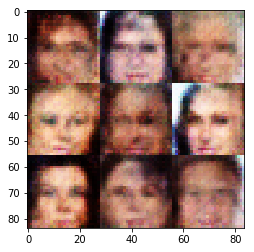

Epoch:0... Batch: 2501... Discriminator Loss: 1.4042... Generator Loss: 0.7352
Epoch:0... Batch: 2502... Discriminator Loss: 1.3974... Generator Loss: 0.7059
Epoch:0... Batch: 2503... Discriminator Loss: 1.4340... Generator Loss: 0.6774
Epoch:0... Batch: 2504... Discriminator Loss: 1.3964... Generator Loss: 0.7596
Epoch:0... Batch: 2505... Discriminator Loss: 1.4409... Generator Loss: 0.6837
Epoch:0... Batch: 2506... Discriminator Loss: 1.4175... Generator Loss: 0.6707
Epoch:0... Batch: 2507... Discriminator Loss: 1.4205... Generator Loss: 0.6883
Epoch:0... Batch: 2508... Discriminator Loss: 1.4031... Generator Loss: 0.7229
Epoch:0... Batch: 2509... Discriminator Loss: 1.4298... Generator Loss: 0.7050
Epoch:0... Batch: 2510... Discriminator Loss: 1.4176... Generator Loss: 0.6679
Epoch:0... Batch: 2511... Discriminator Loss: 1.4285... Generator Loss: 0.7129
Epoch:0... Batch: 2512... Discriminator Loss: 1.3973... Generator Loss: 0.7386
Epoch:0... Batch: 2513... Discriminator Loss: 1.3969

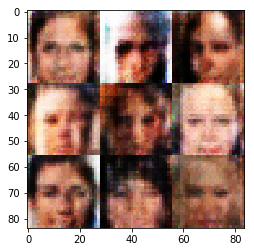

Epoch:0... Batch: 2601... Discriminator Loss: 1.4000... Generator Loss: 0.7429
Epoch:0... Batch: 2602... Discriminator Loss: 1.4144... Generator Loss: 0.7170
Epoch:0... Batch: 2603... Discriminator Loss: 1.4181... Generator Loss: 0.7077
Epoch:0... Batch: 2604... Discriminator Loss: 1.3920... Generator Loss: 0.7426
Epoch:0... Batch: 2605... Discriminator Loss: 1.3804... Generator Loss: 0.7057
Epoch:0... Batch: 2606... Discriminator Loss: 1.3691... Generator Loss: 0.6960
Epoch:0... Batch: 2607... Discriminator Loss: 1.4365... Generator Loss: 0.6862
Epoch:0... Batch: 2608... Discriminator Loss: 1.3791... Generator Loss: 0.7217
Epoch:0... Batch: 2609... Discriminator Loss: 1.3847... Generator Loss: 0.7275
Epoch:0... Batch: 2610... Discriminator Loss: 1.3665... Generator Loss: 0.7399
Epoch:0... Batch: 2611... Discriminator Loss: 1.4323... Generator Loss: 0.6918
Epoch:0... Batch: 2612... Discriminator Loss: 1.4189... Generator Loss: 0.7362
Epoch:0... Batch: 2613... Discriminator Loss: 1.4369

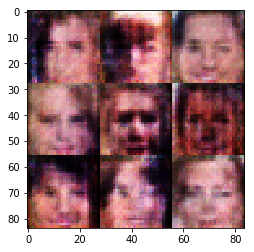

Epoch:0... Batch: 2701... Discriminator Loss: 1.3939... Generator Loss: 0.7375
Epoch:0... Batch: 2702... Discriminator Loss: 1.4063... Generator Loss: 0.7267
Epoch:0... Batch: 2703... Discriminator Loss: 1.4120... Generator Loss: 0.6993
Epoch:0... Batch: 2704... Discriminator Loss: 1.4072... Generator Loss: 0.7055
Epoch:0... Batch: 2705... Discriminator Loss: 1.4358... Generator Loss: 0.7289
Epoch:0... Batch: 2706... Discriminator Loss: 1.4060... Generator Loss: 0.6970
Epoch:0... Batch: 2707... Discriminator Loss: 1.4265... Generator Loss: 0.7012
Epoch:0... Batch: 2708... Discriminator Loss: 1.4528... Generator Loss: 0.7210
Epoch:0... Batch: 2709... Discriminator Loss: 1.4253... Generator Loss: 0.6967
Epoch:0... Batch: 2710... Discriminator Loss: 1.3874... Generator Loss: 0.7021
Epoch:0... Batch: 2711... Discriminator Loss: 1.4164... Generator Loss: 0.7522
Epoch:0... Batch: 2712... Discriminator Loss: 1.4052... Generator Loss: 0.7391
Epoch:0... Batch: 2713... Discriminator Loss: 1.4000

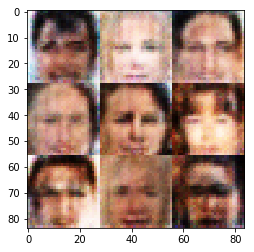

Epoch:0... Batch: 2801... Discriminator Loss: 1.4155... Generator Loss: 0.7527
Epoch:0... Batch: 2802... Discriminator Loss: 1.4095... Generator Loss: 0.7458
Epoch:0... Batch: 2803... Discriminator Loss: 1.3996... Generator Loss: 0.7337
Epoch:0... Batch: 2804... Discriminator Loss: 1.3935... Generator Loss: 0.6923
Epoch:0... Batch: 2805... Discriminator Loss: 1.3978... Generator Loss: 0.6877
Epoch:0... Batch: 2806... Discriminator Loss: 1.4073... Generator Loss: 0.8040
Epoch:0... Batch: 2807... Discriminator Loss: 1.4104... Generator Loss: 0.7407
Epoch:0... Batch: 2808... Discriminator Loss: 1.3972... Generator Loss: 0.6931
Epoch:0... Batch: 2809... Discriminator Loss: 1.4287... Generator Loss: 0.7091
Epoch:0... Batch: 2810... Discriminator Loss: 1.4201... Generator Loss: 0.6556
Epoch:0... Batch: 2811... Discriminator Loss: 1.3929... Generator Loss: 0.6570
Epoch:0... Batch: 2812... Discriminator Loss: 1.4033... Generator Loss: 0.7452
Epoch:0... Batch: 2813... Discriminator Loss: 1.3875

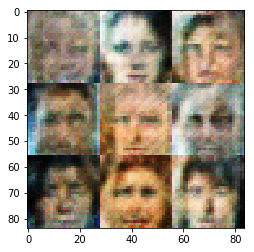

Epoch:0... Batch: 2901... Discriminator Loss: 1.4127... Generator Loss: 0.6925
Epoch:0... Batch: 2902... Discriminator Loss: 1.3750... Generator Loss: 0.7186
Epoch:0... Batch: 2903... Discriminator Loss: 1.4072... Generator Loss: 0.7063
Epoch:0... Batch: 2904... Discriminator Loss: 1.3930... Generator Loss: 0.7529
Epoch:0... Batch: 2905... Discriminator Loss: 1.4033... Generator Loss: 0.7727
Epoch:0... Batch: 2906... Discriminator Loss: 1.4222... Generator Loss: 0.7060
Epoch:0... Batch: 2907... Discriminator Loss: 1.4105... Generator Loss: 0.6849
Epoch:0... Batch: 2908... Discriminator Loss: 1.4463... Generator Loss: 0.7135
Epoch:0... Batch: 2909... Discriminator Loss: 1.4160... Generator Loss: 0.7136
Epoch:0... Batch: 2910... Discriminator Loss: 1.4136... Generator Loss: 0.6969
Epoch:0... Batch: 2911... Discriminator Loss: 1.4071... Generator Loss: 0.6968
Epoch:0... Batch: 2912... Discriminator Loss: 1.4270... Generator Loss: 0.6496
Epoch:0... Batch: 2913... Discriminator Loss: 1.4023

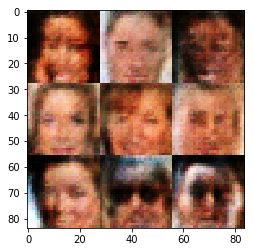

Epoch:0... Batch: 3001... Discriminator Loss: 1.3867... Generator Loss: 0.7204
Epoch:0... Batch: 3002... Discriminator Loss: 1.4624... Generator Loss: 0.6573
Epoch:0... Batch: 3003... Discriminator Loss: 1.4613... Generator Loss: 0.6765
Epoch:0... Batch: 3004... Discriminator Loss: 1.4079... Generator Loss: 0.7940
Epoch:0... Batch: 3005... Discriminator Loss: 1.4162... Generator Loss: 0.7408
Epoch:0... Batch: 3006... Discriminator Loss: 1.4239... Generator Loss: 0.6570
Epoch:0... Batch: 3007... Discriminator Loss: 1.3967... Generator Loss: 0.6854
Epoch:0... Batch: 3008... Discriminator Loss: 1.3992... Generator Loss: 0.7008
Epoch:0... Batch: 3009... Discriminator Loss: 1.3917... Generator Loss: 0.7156
Epoch:0... Batch: 3010... Discriminator Loss: 1.3818... Generator Loss: 0.7284
Epoch:0... Batch: 3011... Discriminator Loss: 1.4350... Generator Loss: 0.7148
Epoch:0... Batch: 3012... Discriminator Loss: 1.4171... Generator Loss: 0.7262
Epoch:0... Batch: 3013... Discriminator Loss: 1.4135

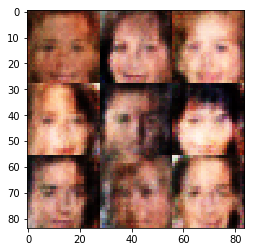

Epoch:0... Batch: 3101... Discriminator Loss: 1.3898... Generator Loss: 0.6651
Epoch:0... Batch: 3102... Discriminator Loss: 1.4351... Generator Loss: 0.7210
Epoch:0... Batch: 3103... Discriminator Loss: 1.4503... Generator Loss: 0.7434
Epoch:0... Batch: 3104... Discriminator Loss: 1.4258... Generator Loss: 0.6857
Epoch:0... Batch: 3105... Discriminator Loss: 1.3806... Generator Loss: 0.6681
Epoch:0... Batch: 3106... Discriminator Loss: 1.3984... Generator Loss: 0.7041
Epoch:0... Batch: 3107... Discriminator Loss: 1.3967... Generator Loss: 0.7356
Epoch:0... Batch: 3108... Discriminator Loss: 1.4382... Generator Loss: 0.7131
Epoch:0... Batch: 3109... Discriminator Loss: 1.3969... Generator Loss: 0.7140
Epoch:0... Batch: 3110... Discriminator Loss: 1.4453... Generator Loss: 0.7429
Epoch:0... Batch: 3111... Discriminator Loss: 1.4093... Generator Loss: 0.7781
Epoch:0... Batch: 3112... Discriminator Loss: 1.3869... Generator Loss: 0.7676
Epoch:0... Batch: 3113... Discriminator Loss: 1.3952

In [120]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.